In [10]:
import numpy as np
from skimage.measure import block_reduce
import matplotlib.pyplot as plt
from scipy import optimize
from pandas import DataFrame
import math
import scipy.optimize as opt

data_filename = "./data/lateral_calibration.csv"
data = np.loadtxt(data_filename,delimiter=",")   

%matplotlib inline

In [11]:
data = np.array([data])
data

array([[  27.,   31.,  390.,   42.,   42., 1904.,   54.,   45.,   47.,
          37.,   40.,   42.,   38.,   40.,   56.,   59.,   64.,   58.,
         128.,  176.,  309.,  346.,  464.,  518.,  625.,  669.,  663.,
        1001.,  603.,  556.,  467.,  373.,  282.,  176.,  117.,   90.,
          61.,   65.,   39.,   45.]])

In [14]:
angles = []
angle_step = 10
for i in range(len(data)):
    angles.append(i*angle_step)
print(angles)

[0]


Now that that's loaded, we'll us matplotlib's `imshow` command to display our data as a 2d image with intensity coded as color.  

`extent` here is used to define the `x` and `y` axis start and end values

`aspect="auto"` makes the plot square instead of long & thin.

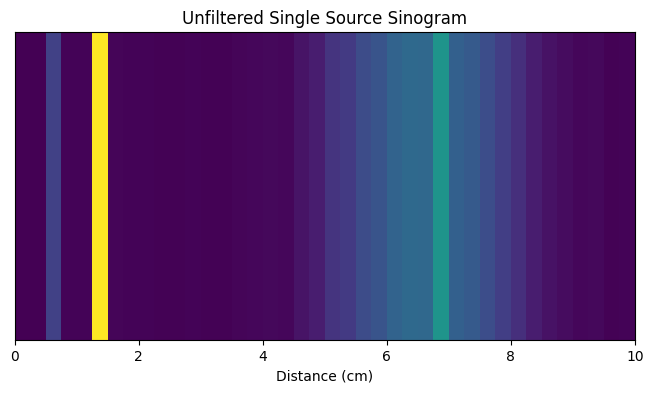

In [13]:
fig,ax = plt.subplots(figsize = (8,4))
start_dist = 0
end_dist = 10
start_angle = 1
end_angle = angles[-1]  # This is the last angle in the array, no matter how many angles are in it.
ax.imshow(data,extent=[start_dist,end_dist,end_angle,start_angle],aspect="auto")
ax.set_xlabel("Distance (cm)")
ax.set_ylabel("Angle (degrees)")
ax.get_yaxis().set_visible(False)
ax.set_title("Unfiltered Single Source Sinogram");

#fig.savefig('1-source_sinogram.png')
plt.show()

In [6]:
#this is our data fitting function for feature location identification

def data_fit(p0, func, xvar, yvar, err, tmi=0):
    try:
        fit = optimize.least_squares(residual, p0, args=(func,xvar, yvar, err), verbose=tmi)
    except Exception as error:
        print("Something has gone wrong:",error)
        return p0, np.zeros_like(p0), -1, -1
    pf = fit['x']

    print()

    try:
        cov = np.linalg.inv(fit['jac'].T.dot(fit['jac']))
        # This computes a covariance matrix by finding the inverse of the Jacobian times its transpose
        # We need this to find the uncertainty in our fit parameters
    except:
        # If the fit failed, print the reason
        print('Fit did not converge')
        print('Result is likely a local minimum')
        print('Try changing initial values')
        print('Status code:', fit['status'])
        print(fit['message'])
        return pf, np.zeros_like(pf), -1, -1
            #You'll be able to plot with this, but it will not be a good fit.

    chisq = sum(residual(pf, func, xvar, yvar, err) **2)
    dof = len(xvar) - len(pf)
    red_chisq = chisq/dof
    pferr = np.sqrt(np.diagonal(cov)) # finds the uncertainty in fit parameters by squaring diagonal elements of the covariance matrix
    pfcov = cov[0,1]
    print('Converged with chi-squared {:.2f}'.format(chisq))
    print('Number of degrees of freedom, dof = {:.2f}'.format(dof))
    print('Reduced chi-squared {:.2f}'.format(red_chisq))
    print()
    Columns = ["Parameter #","Initial guess values:", "Best fit values:", "Uncertainties in the best fit values:"]
    print('{:<11}'.format(Columns[0]),'|','{:<24}'.format(Columns[1]),"|",'{:<24}'.format(Columns[2]),"|",'{:<24}'.format(Columns[3]))
    for num in range(len(pf)):
        print('{:<11}'.format(num),'|','{:<24.3e}'.format(p0[num]),'|','{:<24.3e}'.format(pf[num]),'|','{:<24.3e}'.format(pferr[num]))
    return pf, pferr, chisq, dof

def residual(p,func, xvar, yvar, err):
    return (func(p, xvar) - yvar)/err

def gaussianfunc_bg(p,x):
    return p[0]/(p[2]*np.sqrt(2*np.pi))*np.exp(-(x-p[1])**2/(2*p[2]**2))+p[3]*x+p[4]

In [33]:
x = []
step = 0.25
while step <=10:
    x.append(step)
    step += 0.25
x = np.array(x)

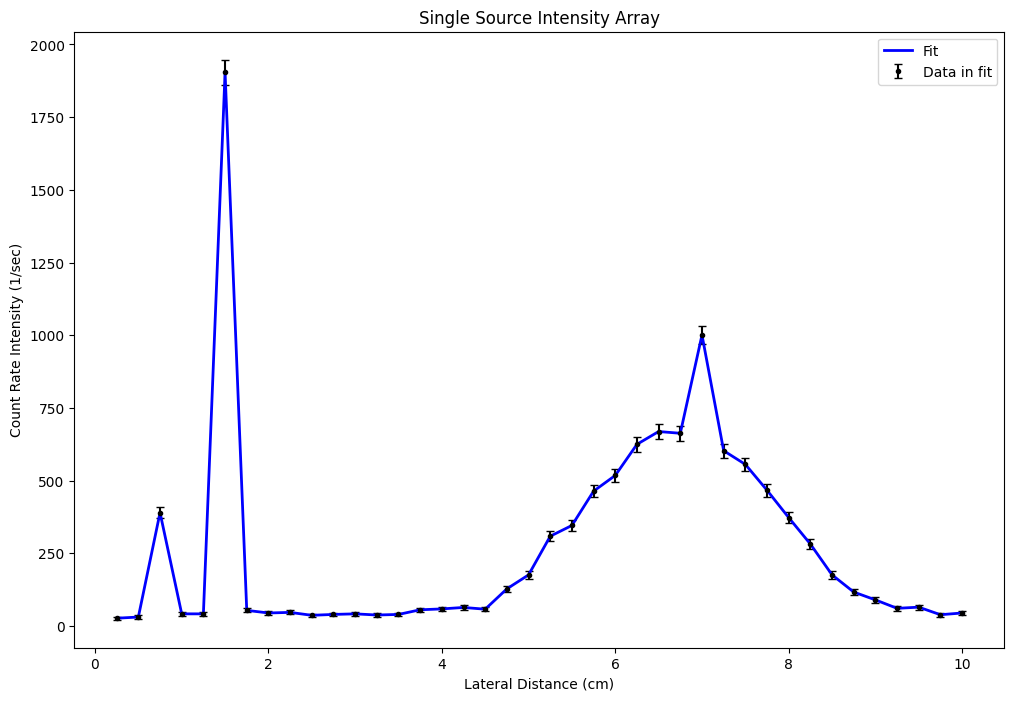

In [34]:
y = data[0]
dy = np.sqrt(y)

fig,ax = plt.subplots(figsize = (12,8))
ax.errorbar(x, y, yerr = dy,fmt= 'k.', capsize = 3, label='Data in fit')
ax.plot(x, y, color = 'blue', linewidth = 2, label='Fit')

ax.set_title('Single Source Intensity Array')
ax.set_xlabel('Lateral Distance (cm)')
ax.set_ylabel('Count Rate Intensity (1/sec)')
ax.legend()

#plt.savefig('1-source-array.png')

In [9]:
#we can include a data smoothing function that allows us to applying localized signal smoothing

def get_avg(list,i):
    sum = 0
    div = 0
    for offset_i in [-1,0,1]:
        new_i = i + offset_i
        if (new_i >= 0 and new_i < len(list)):
            sum += list[new_i]
            div += 1
    avg = (sum - list[i])/(div-1)
    return avg


def n_avg(list, i, j):
    sum = 0
    div = 0
    for offset_i in [-1,0, 1]:
        for offset_j in [-1,0, 1]:
            new_i = i + offset_i
            new_j = j + offset_j
            if (new_i >= 0 and new_j >= 0 and new_i < len(list) and new_j < len(list)):
                sum += list[new_i][new_j]
                div += 1
    avg = (sum-list[i][j]) / (div-1)
    return avg


def smoothing(list):
    for x in range(0,len(list)):
        if list[x] > 1.25*get_avg(list,x):
            list[x] = get_avg(list,x)
    return(list)

smoothing(data[0])

array([ 27. ,  31. ,  36.5,  42. ,  42. ,  48. ,  54. ,  45. ,  47. ,
        37. ,  40. ,  42. ,  38. ,  40. ,  56. ,  59. ,  64. ,  58. ,
       128. , 176. , 309. , 346. , 464. , 518. , 625. , 669. , 663. ,
       633. , 603. , 556. , 467. , 373. , 282. , 176. , 117. ,  90. ,
        61. ,  50. ,  39. ,  45. ])

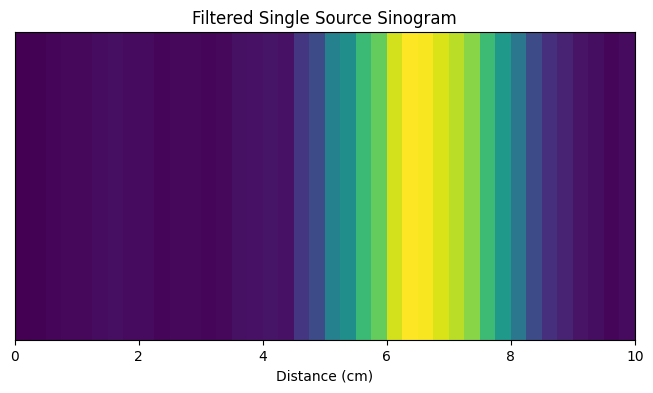

In [10]:
fig,ax = plt.subplots(figsize = (8,4))
start_dist = 0
end_dist = 10
start_angle = 1
end_angle = angles[-1]  # This is the last angle in the array, no matter how many angles are in it.
ax.imshow(data,extent=[start_dist,end_dist,end_angle,start_angle],aspect="auto")
ax.set_xlabel("Distance (cm)")
ax.set_ylabel("Angle (degrees)")
ax.get_yaxis().set_visible(False)
ax.set_title("Filtered Single Source Sinogram");

#fig.savefig('1-source_sinogram-corrected.png')

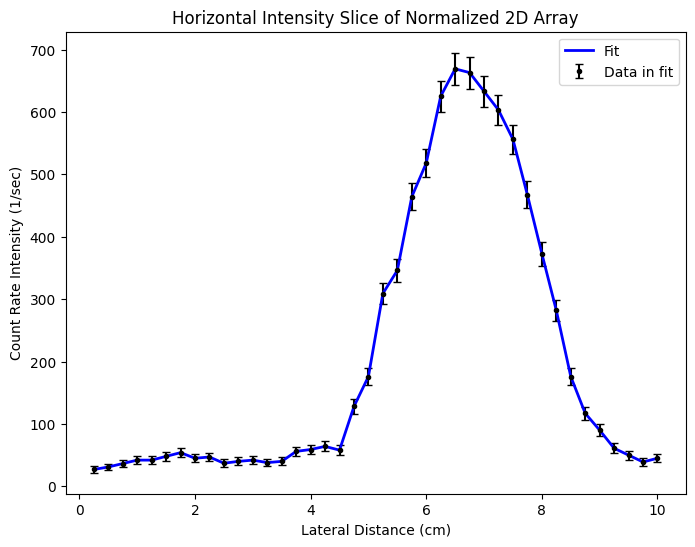

In [11]:
y = data[0]
dy = np.sqrt(y)

fig,ax = plt.subplots(figsize = (8,6))


ax.errorbar(x, y, yerr = dy,fmt= 'k.', capsize = 3, label='Data in fit')
ax.plot(x, y, color = 'blue', linewidth = 2, label='Fit')



ax.set_title('Horizontal Intensity Slice of Normalized 2D Array')
ax.set_xlabel('Lateral Distance (cm)')
ax.set_ylabel('Count Rate Intensity (1/sec)')
ax.legend()

#plt.savefig('2source-horizontal.png')


Converged with chi-squared 20.99
Number of degrees of freedom, dof = 16.00
Reduced chi-squared 1.31

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 2.000e+03                | 1.952e+03                | 8.019e+01               
1           | 6.750e+00                | 6.702e+00                | 2.389e-02               
2           | 1.000e+00                | 1.122e+00                | 3.226e-02               
3           | 1.000e+01                | 1.017e+01                | 3.109e+00               
4           | 1.000e+01                | -8.472e+01               | 3.200e+01               
[4.5       4.5010002 4.5020004 ... 9.4979996 9.4989998 9.5      ]


Text(0, 0.5, 'Count Rate Intensity (1/sec)')

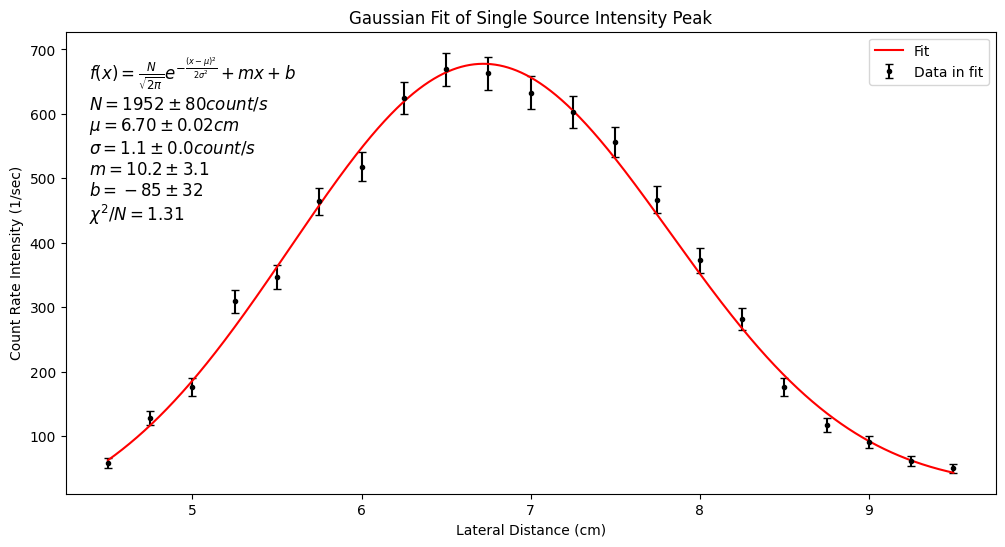

In [12]:
guess = [2000,6.75,1,10,10]

min_value = 17
max_value = 38

pf, pferr, chisq, dof = data_fit(guess, gaussianfunc_bg, x[min_value:max_value], y[min_value:max_value], dy[min_value:max_value])

fig,ax = plt.subplots(figsize = (12,6))

ax.errorbar(x[min_value:max_value], y[min_value:max_value], yerr=dy[min_value:max_value],fmt= 'k.', capsize = 3, label='Data in fit')
channel_cont = np.linspace(min(x[min_value:max_value]), max(x[min_value:max_value]), 5000)

print(channel_cont)
ax.plot(channel_cont, gaussianfunc_bg(pf, channel_cont), 'r-', label='Fit')


#f(x) = \frac{N}{\sqrt{2\pi }}e^{-\frac{(x-\mu)^2}{2\sigma^2 }}
textfit = '$f(x) = \\frac{N}{\sqrt{2\pi }}e^{-\\frac{(x-\mu)^2}{2\sigma^2 }}+mx+b$\n' 
textfit += '$N = {:.0f} \pm {:.0f} count/s$ \n'.format(pf[0],pferr[0]) 
textfit += '$\mu = {:.2f} \pm {:.2f} cm$ \n'.format(pf[1],pferr[1]) 
textfit += '$\sigma = {:.1f} \pm {:.1f} count/s$ \n'.format(pf[2],pferr[2])
textfit += '$m = {:.1f} \pm {:.1f}$ \n'.format(pf[3],pferr[3]) 
textfit += '$b = {:.0f} \pm {:.0f}$ \n'.format(pf[4],pferr[4]) 
textfit += '$\chi^2 / N = {:.2f}$ \n'.format(chisq/dof) 
ax.text(0.025, 0.95, textfit, transform=ax.transAxes , fontsize=12,verticalalignment='top')

ax.set_title('Gaussian Fit of Single Source Intensity Peak')
ax.legend()
ax.set_xlabel('Lateral Distance (cm)')
ax.set_ylabel('Count Rate Intensity (1/sec)')

#plt.savefig('1-source-peak.png')

Now we have an inverse problem:  We know what the intensity of our source looks like as a function of distance and angle, but we want to know it in terms of x and y position.

There are a number of ways we can go about doing this, but we'll start with the simplest first: projecting out our slices along the line of response for the detectors, rotating these projections by their associated angles, and then combining all these together to get a composite plot.

To project out out slices, we'll use `np.outer` to do an outer product; this turns our 1d slices into 2d matricies.

The doce below does this for each slice in our data, and plots the results for the first and second slices.

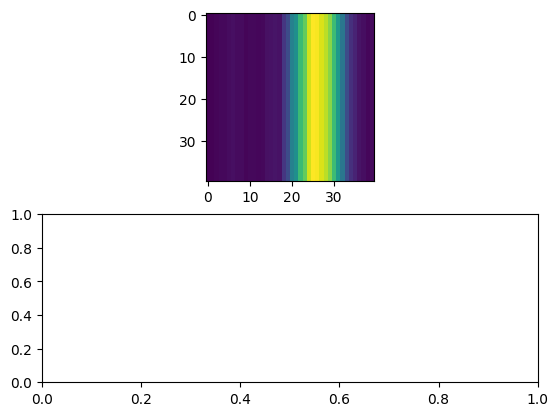

In [13]:
from scipy import ndimage
expand_vec = np.ones(data[0].size)  # this is used to get us a square matrix
expanded_data = []
for item in data:
    expanded_data.append(np.outer(expand_vec,item))
    
fig, (ax,ay) = plt.subplots(2)
ax.imshow(expanded_data[0])

Okay, we've made 2d representations of our data.  Now how do we rotate them?  Instead of writing code to do matrix rotation ourselves, we'll use scipy's `ndimage` library.  Unless you manually want to write a matrix rotation algorithm.  I'm not your boss, knock yourself out.

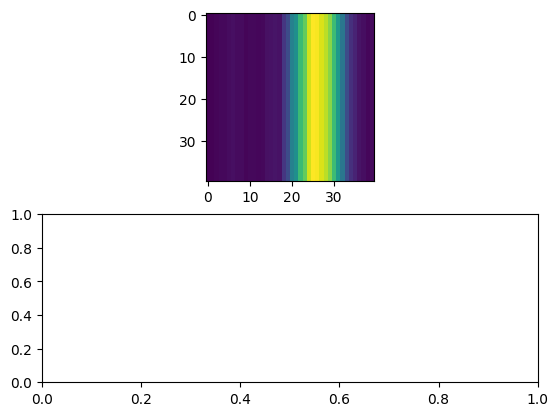

In [14]:
rotated_data = []
for index, item in enumerate(expanded_data):
    rotated_data.append(ndimage.rotate(item,angles[index],reshape=False,order=1)) # we want Numpy to keep our square, 2d matricies.
    
fig, (ax,ay) = plt.subplots(2)
ax.imshow(rotated_data[0])


The rotated part has some bad aliasing going on, but it more-or-less captures the results of our third scan.  We'll show how to reduce that a bit later, but for now let's start recombining data!

To do this, we'll make a composite image by multiplying each of these expanded & rotated slices together.  Locations where we don't see many coincidences at any angle will end up with low counts, and locations with lots of coincidences at similar angles will end up with high counts.  It may be easier to see what this looks like, so let's start by recombining just the first and third slices.

We'll also normalize the data by taking the `nth` root, where `n` is the number of slices we're using.  The units would end up being something insane if we didn't do this.

# Filtering Rotated Data

In [15]:
def n_avg(list, i, j):
    sum = 0
    div = 0
    for offset_i in [-1,0, 1]:
        for offset_j in [-1,0, 1]:
            new_i = i + offset_i
            new_j = j + offset_j
            if (new_i >= 0 and new_j >= 0 and new_i < len(list) and new_j < len(list)):
                sum += list[new_i][new_j]
                div += 1
    avg = (sum-list[i][j]) / (div-1)
    return avg

def smoothing(list):
    for x in range(0,len(list)):
        for y in range(0,len(list)):
            if list[x][y] > 1.25*n_avg(list,x,y):
                list[x][y] = n_avg(list,x,y)
    return(list)
                

In [16]:
runs = 0 
while runs < 500:
    for i in range(0,len(rotated_data)):
        smoothing(rotated_data[i])
    runs += 1

In [18]:
composite = rotated_data[0] * rotated_data[1]
normalized = np.power(composite,(1/2))

fig, ax = plt.subplots()
ax.imshow(normalized)

IndexError: list index out of range

You should now have some smears or blobs in your image instead of just straight lines.  Let's go ahead and go through the entire thing and see what we get.

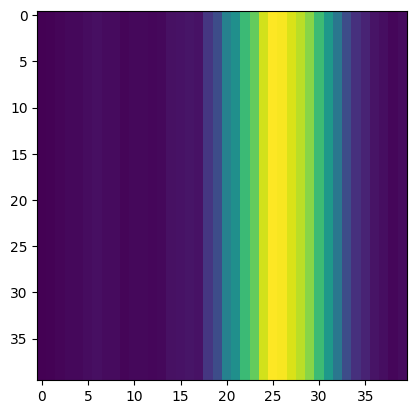

In [19]:
composite = np.ones_like(rotated_data[0]) # We need a matrix full of 1s to start out with, we can't multiply an empty matrix with anything.
for item in rotated_data:
    composite *= item
normalized = np.power(composite,(1/len(rotated_data))) #

fig, ax = plt.subplots()
ax.imshow(normalized)
#fig.savefig('2_source_sinogram.png')

While likely quite blurry, you should have something that now at least vaguely resembles a few point sources.  Congratulations, you've now got the basics down!

# Peak Detection

In [20]:
from findpeaks import findpeaks

ModuleNotFoundError: No module named 'findpeaks'

In [21]:
fp = findpeaks(method='topology')
results = fp.fit(normalized)
fp.plot()

NameError: name 'findpeaks' is not defined

In [22]:
results['persistence']

NameError: name 'results' is not defined

The two points are (27,27) and (13,26)

The goal of the findpeaks function is to ensure our peaks are statistically significant candidates and to find ball park what is the point of highest count rate. We now run two Gaussian fits for each of the peaks to find its precise location and uncertainty.

# Horizontal Gaussian Fits

In [645]:
def data_fit(p0, func, xvar, yvar, err, tmi=0):
    try:
        fit = optimize.least_squares(residual, p0, args=(func,xvar, yvar, err), verbose=tmi)
    except Exception as error:
        print("Something has gone wrong:",error)
        return p0, np.zeros_like(p0), -1, -1
    pf = fit['x']

    print()

    try:
        cov = np.linalg.inv(fit['jac'].T.dot(fit['jac']))          
        # This computes a covariance matrix by finding the inverse of the Jacobian times its transpose
        # We need this to find the uncertainty in our fit parameters
    except:
        # If the fit failed, print the reason
        print('Fit did not converge')
        print('Result is likely a local minimum')
        print('Try changing initial values')
        print('Status code:', fit['status'])
        print(fit['message'])
        return pf, np.zeros_like(pf), -1, -1
            #You'll be able to plot with this, but it will not be a good fit.

    chisq = sum(residual(pf, func, xvar, yvar, err) **2)
    dof = len(xvar) - len(pf)
    red_chisq = chisq/dof
    pferr = np.sqrt(np.diagonal(cov)) # finds the uncertainty in fit parameters by squaring diagonal elements of the covariance matrix
    pfcov = cov[0,1]
    print('Converged with chi-squared {:.2f}'.format(chisq))
    print('Number of degrees of freedom, dof = {:.2f}'.format(dof))
    print('Reduced chi-squared {:.2f}'.format(red_chisq))
    print()
    Columns = ["Parameter #","Initial guess values:", "Best fit values:", "Uncertainties in the best fit values:"]
    print('{:<11}'.format(Columns[0]),'|','{:<24}'.format(Columns[1]),"|",'{:<24}'.format(Columns[2]),"|",'{:<24}'.format(Columns[3]))
    for num in range(len(pf)):
        print('{:<11}'.format(num),'|','{:<24.3e}'.format(p0[num]),'|','{:<24.3e}'.format(pf[num]),'|','{:<24.3e}'.format(pferr[num]))
    return pf, pferr, chisq, dof

def residual(p,func, xvar, yvar, err):
    return (func(p, xvar) - yvar)/err

def gaussianfunc_bg(p,x):
    return p[0]/(p[2]*np.sqrt(2*np.pi))*np.exp(-(x-p[1])**2/(2*p[2]**2))+p[3]*x+p[4]

In [646]:
x = []
step = 0.5
while step <= 28:
    x.append(step)
    step += 0.5
    
x = np.array(x)

<IPython.core.display.Javascript object>


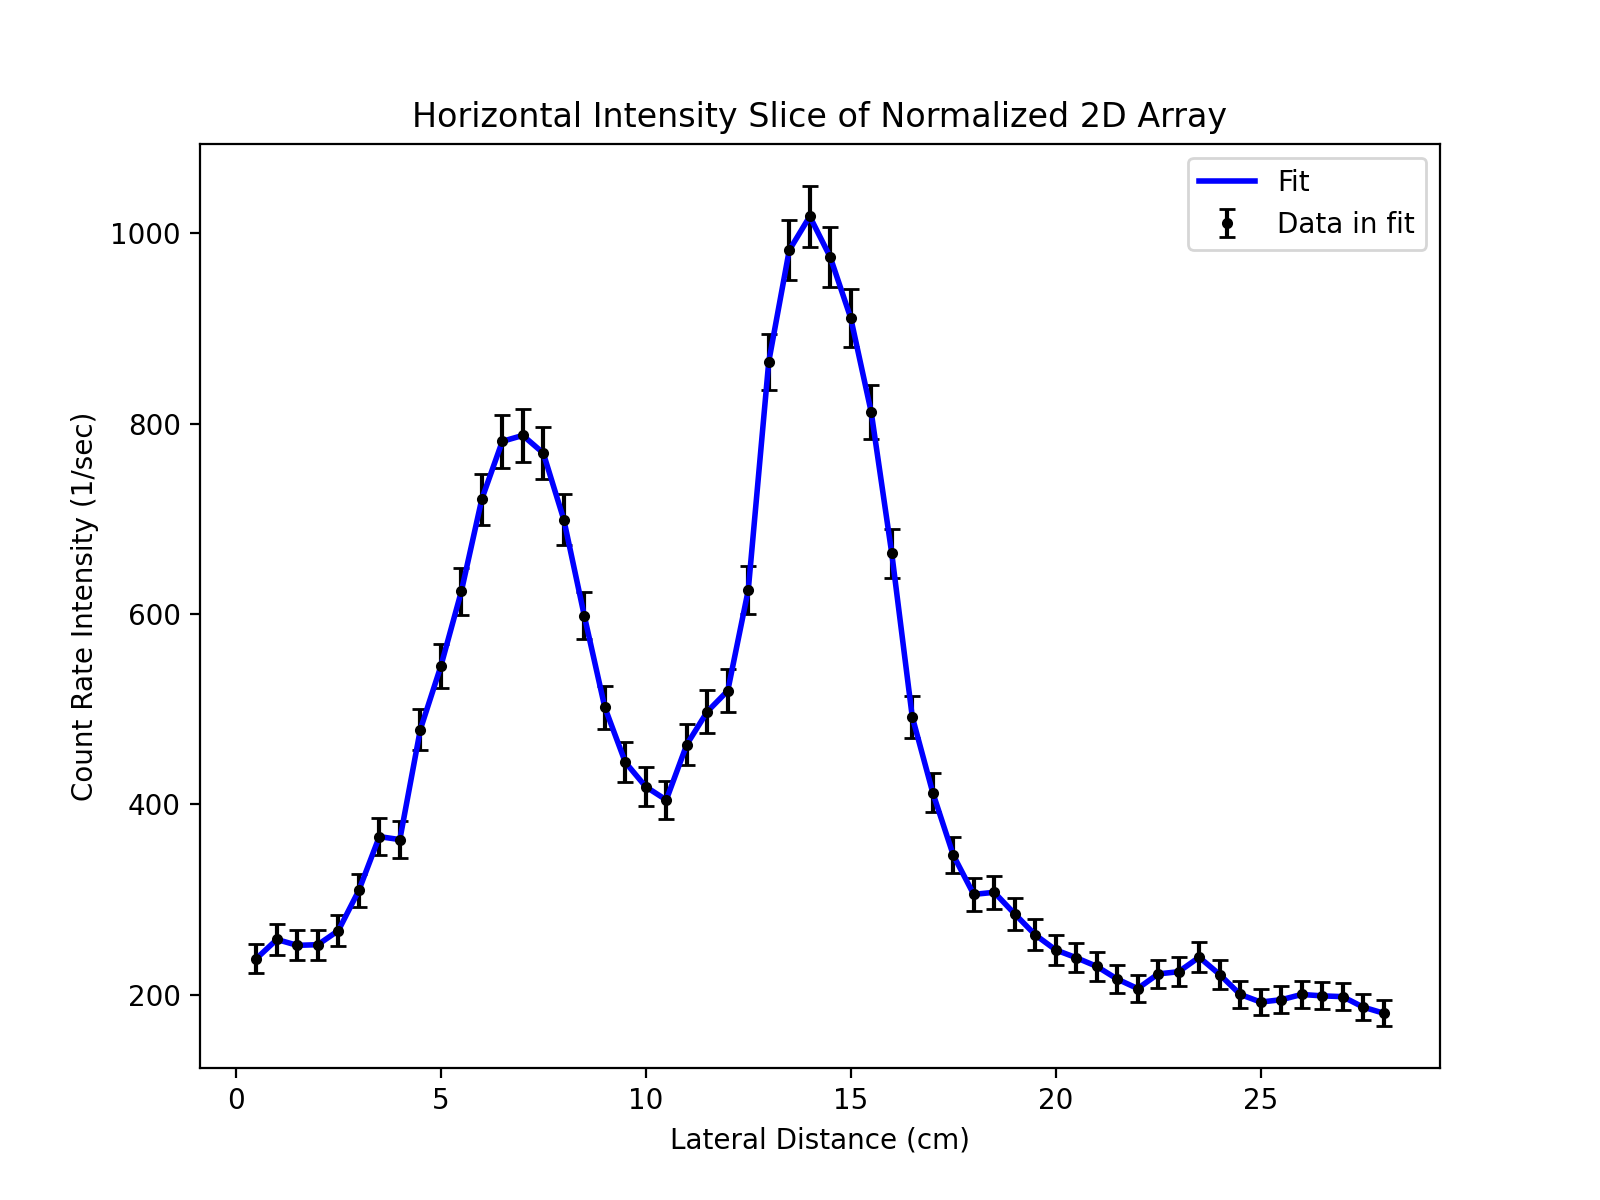

In [647]:
y = normalized[26]
dy = np.sqrt(y)

fig,ax = plt.subplots(figsize = (8,6))


ax.errorbar(x, y, yerr = dy,fmt= 'k.', capsize = 3, label='Data in fit')
ax.plot(x, y, color = 'blue', linewidth = 2, label='Fit')



ax.set_title('Horizontal Intensity Slice of Normalized 2D Array')
ax.set_xlabel('Lateral Distance (cm)')
ax.set_ylabel('Count Rate Intensity (1/sec)')
ax.legend()

plt.savefig('2source-horizontal.png')


Converged with chi-squared 4.10
Number of degrees of freedom, dof = 8.00
Reduced chi-squared 0.51

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 8.000e+03                | 1.908e+03                | 3.504e+02               
1           | 7.000e+00                | 6.795e+00                | 9.536e-02               
2           | 2.000e+00                | 1.571e+00                | 1.661e-01               
3           | 1.000e+01                | 1.169e+01                | 6.688e+00               
4           | 1.000e+01                | 2.307e+02                | 7.667e+01               


<IPython.core.display.Javascript object>


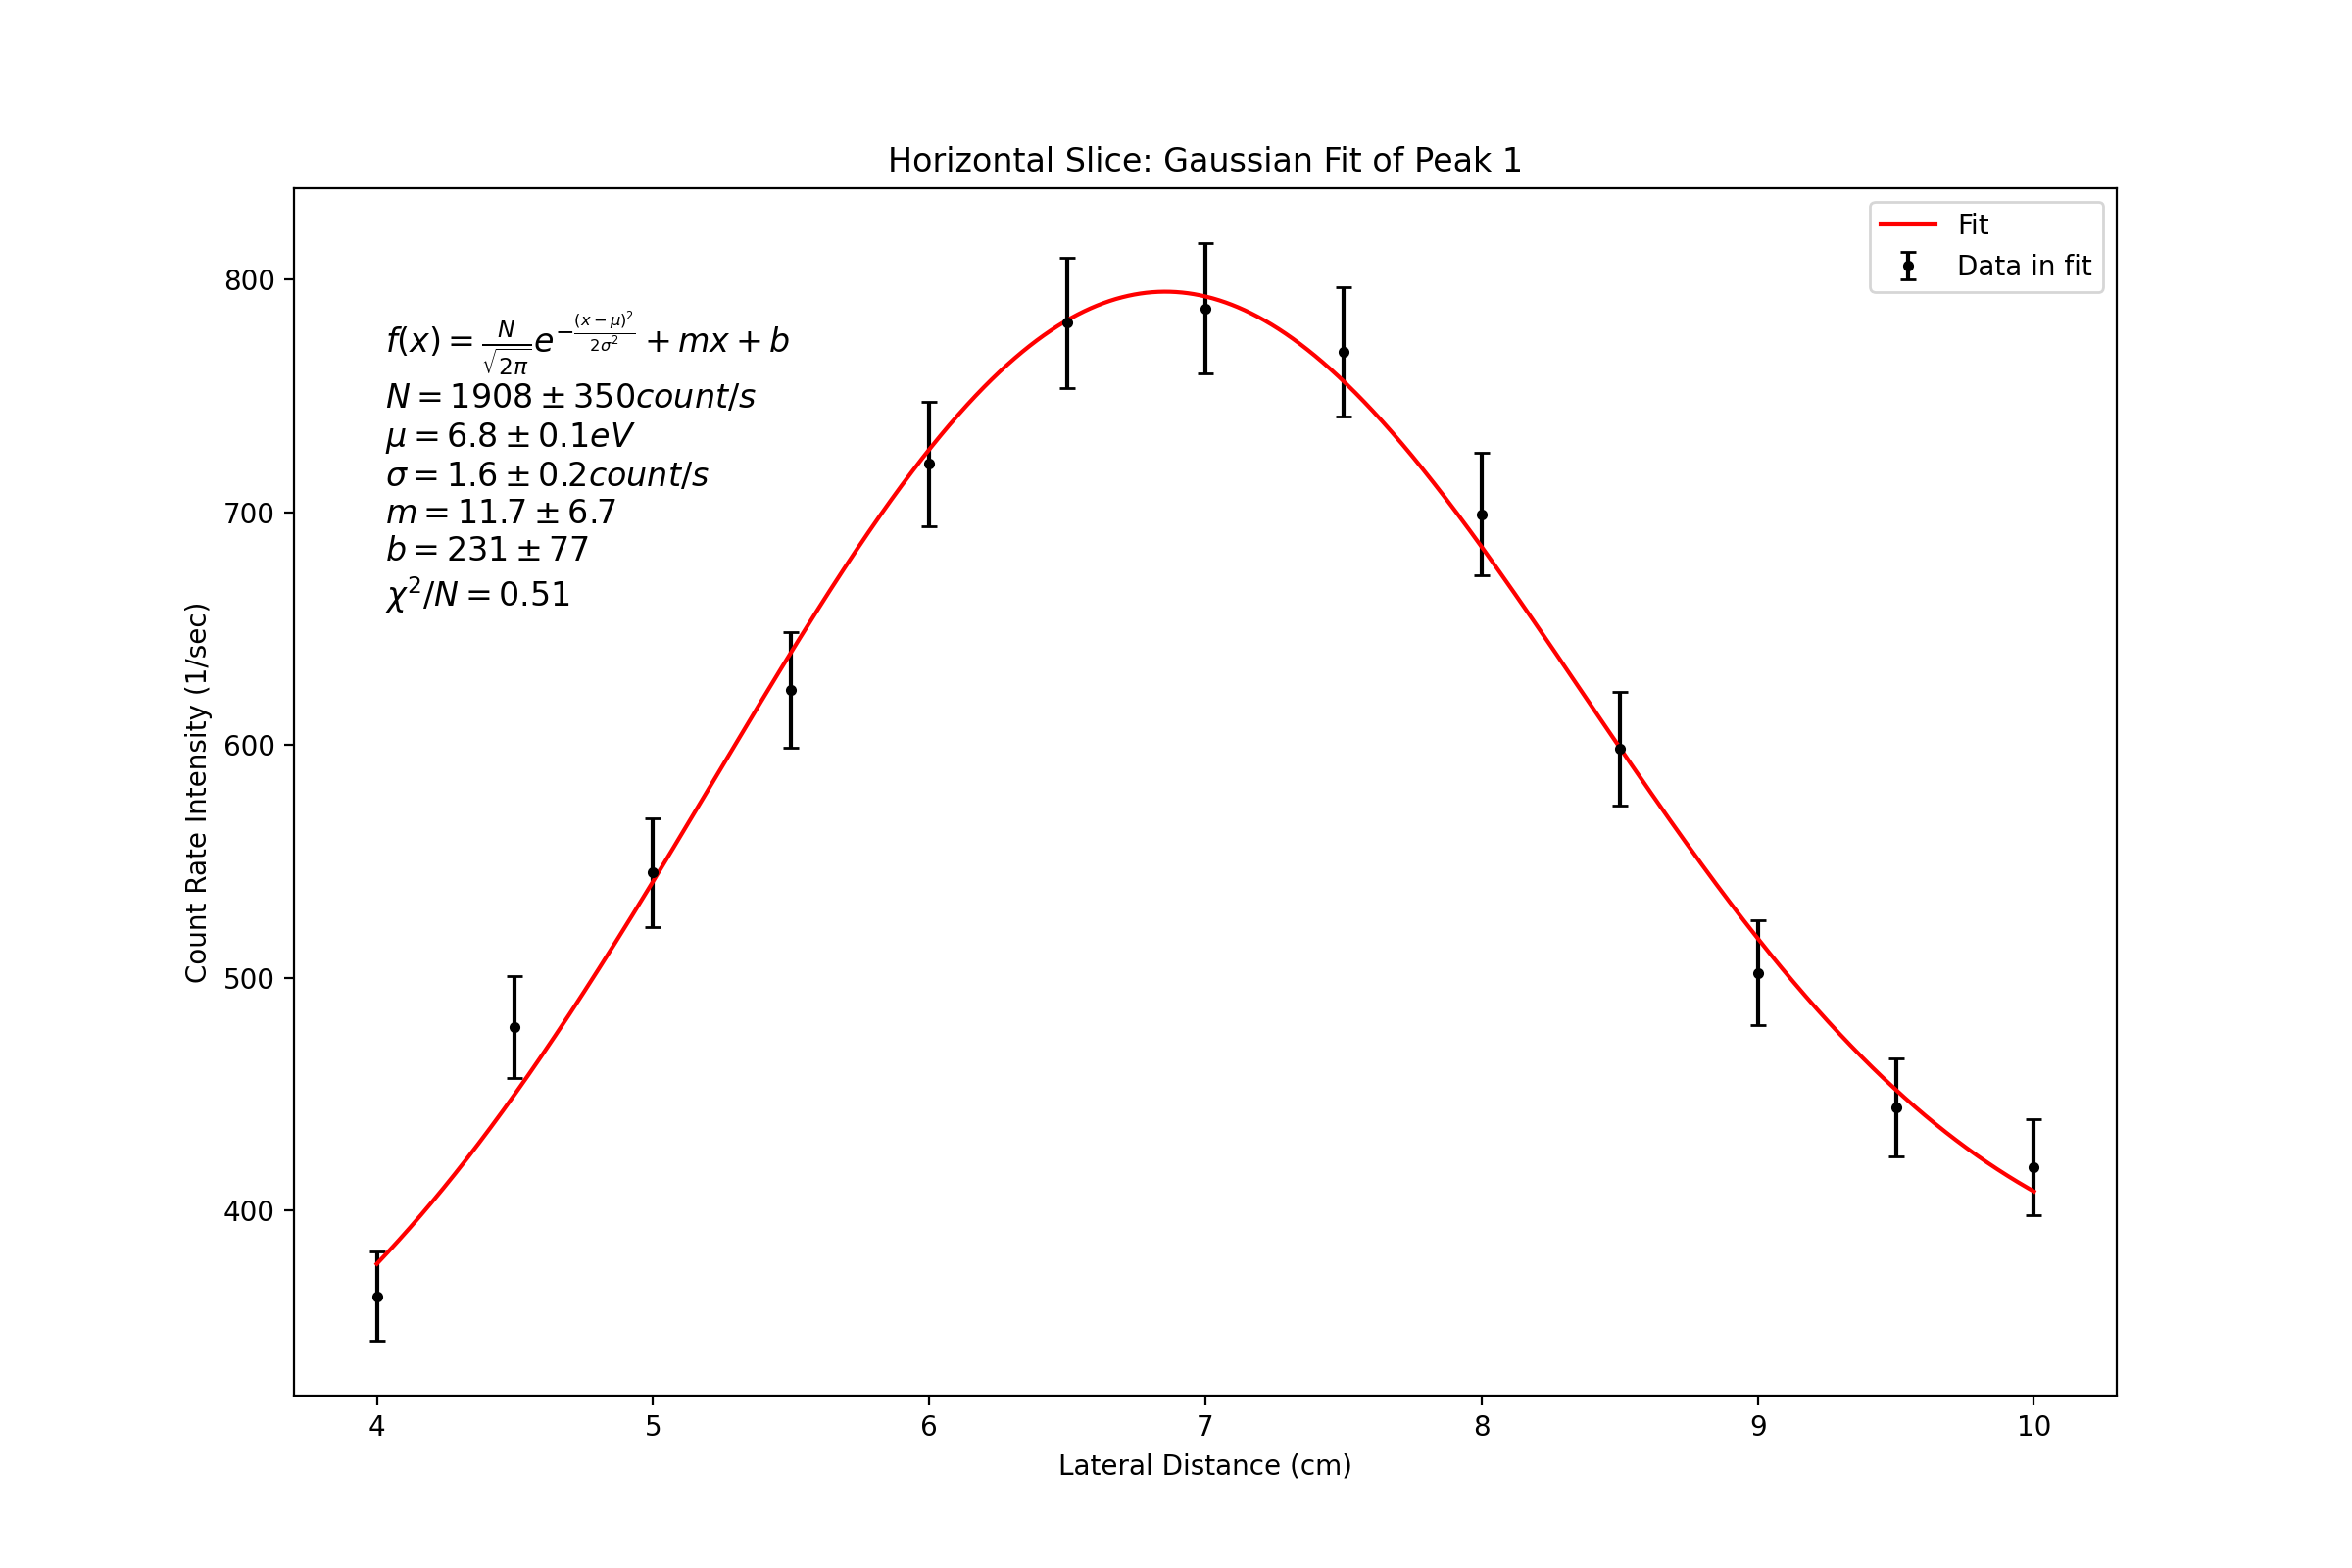

[ 4.          4.00120024  4.00240048 ...  9.99759952  9.99879976
 10.        ]


In [658]:
guess = [8000,7,2,10,10]

min_value = 7
max_value = 20

pf, pferr, chisq, dof = data_fit(guess, gaussianfunc_bg, x[min_value:max_value], y[min_value:max_value], dy[min_value:max_value])

fig,ax = plt.subplots(figsize = (12,8))

ax.errorbar(x[min_value:max_value], y[min_value:max_value], yerr=dy[min_value:max_value],fmt= 'k.', capsize = 3, label='Data in fit')
channel_cont = np.linspace(min(x[min_value:max_value]), max(x[min_value:max_value]), 5000)

print(channel_cont)
ax.plot(channel_cont, gaussianfunc_bg(pf, channel_cont), 'r-', label='Fit')


#f(x) = \frac{N}{\sqrt{2\pi }}e^{-\frac{(x-\mu)^2}{2\sigma^2 }}
textfit = '$f(x) = \\frac{N}{\sqrt{2\pi }}e^{-\\frac{(x-\mu)^2}{2\sigma^2 }}+mx+b$\n' 
textfit += '$N = {:.0f} \pm {:.0f} count/s$ \n'.format(pf[0],pferr[0]) 
textfit += '$\mu = {:.1f} \pm {:.1f} eV$ \n'.format(pf[1],pferr[1]) 
textfit += '$\sigma = {:.1f} \pm {:.1f} count/s$ \n'.format(pf[2],pferr[2])
textfit += '$m = {:.1f} \pm {:.1f}$ \n'.format(pf[3],pferr[3]) 
textfit += '$b = {:.0f} \pm {:.0f}$ \n'.format(pf[4],pferr[4]) 
textfit += '$\chi^2 / N = {:.2f}$ \n'.format(chisq/dof) 
ax.text(0.05, 0.90, textfit, transform=ax.transAxes , fontsize=12,verticalalignment='top')

ax.set_title('Horizontal Slice: Gaussian Fit of Peak 1')
ax.legend()
ax.set_xlabel('Lateral Distance (cm)')
ax.set_ylabel('Count Rate Intensity (1/sec)')

plt.savefig('2source-peak1-horizontal.png')


Converged with chi-squared 16.01
Number of degrees of freedom, dof = 9.00
Reduced chi-squared 1.78

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 3.000e+03                | 2.445e+03                | 2.162e+02               
1           | 1.200e+01                | 1.428e+01                | 5.766e-02               
2           | 2.000e+00                | 1.408e+00                | 7.920e-02               
3           | 1.000e+01                | -1.252e+01               | 6.018e+00               
4           | 1.000e+01                | 5.136e+02                | 1.112e+02               


<IPython.core.display.Javascript object>


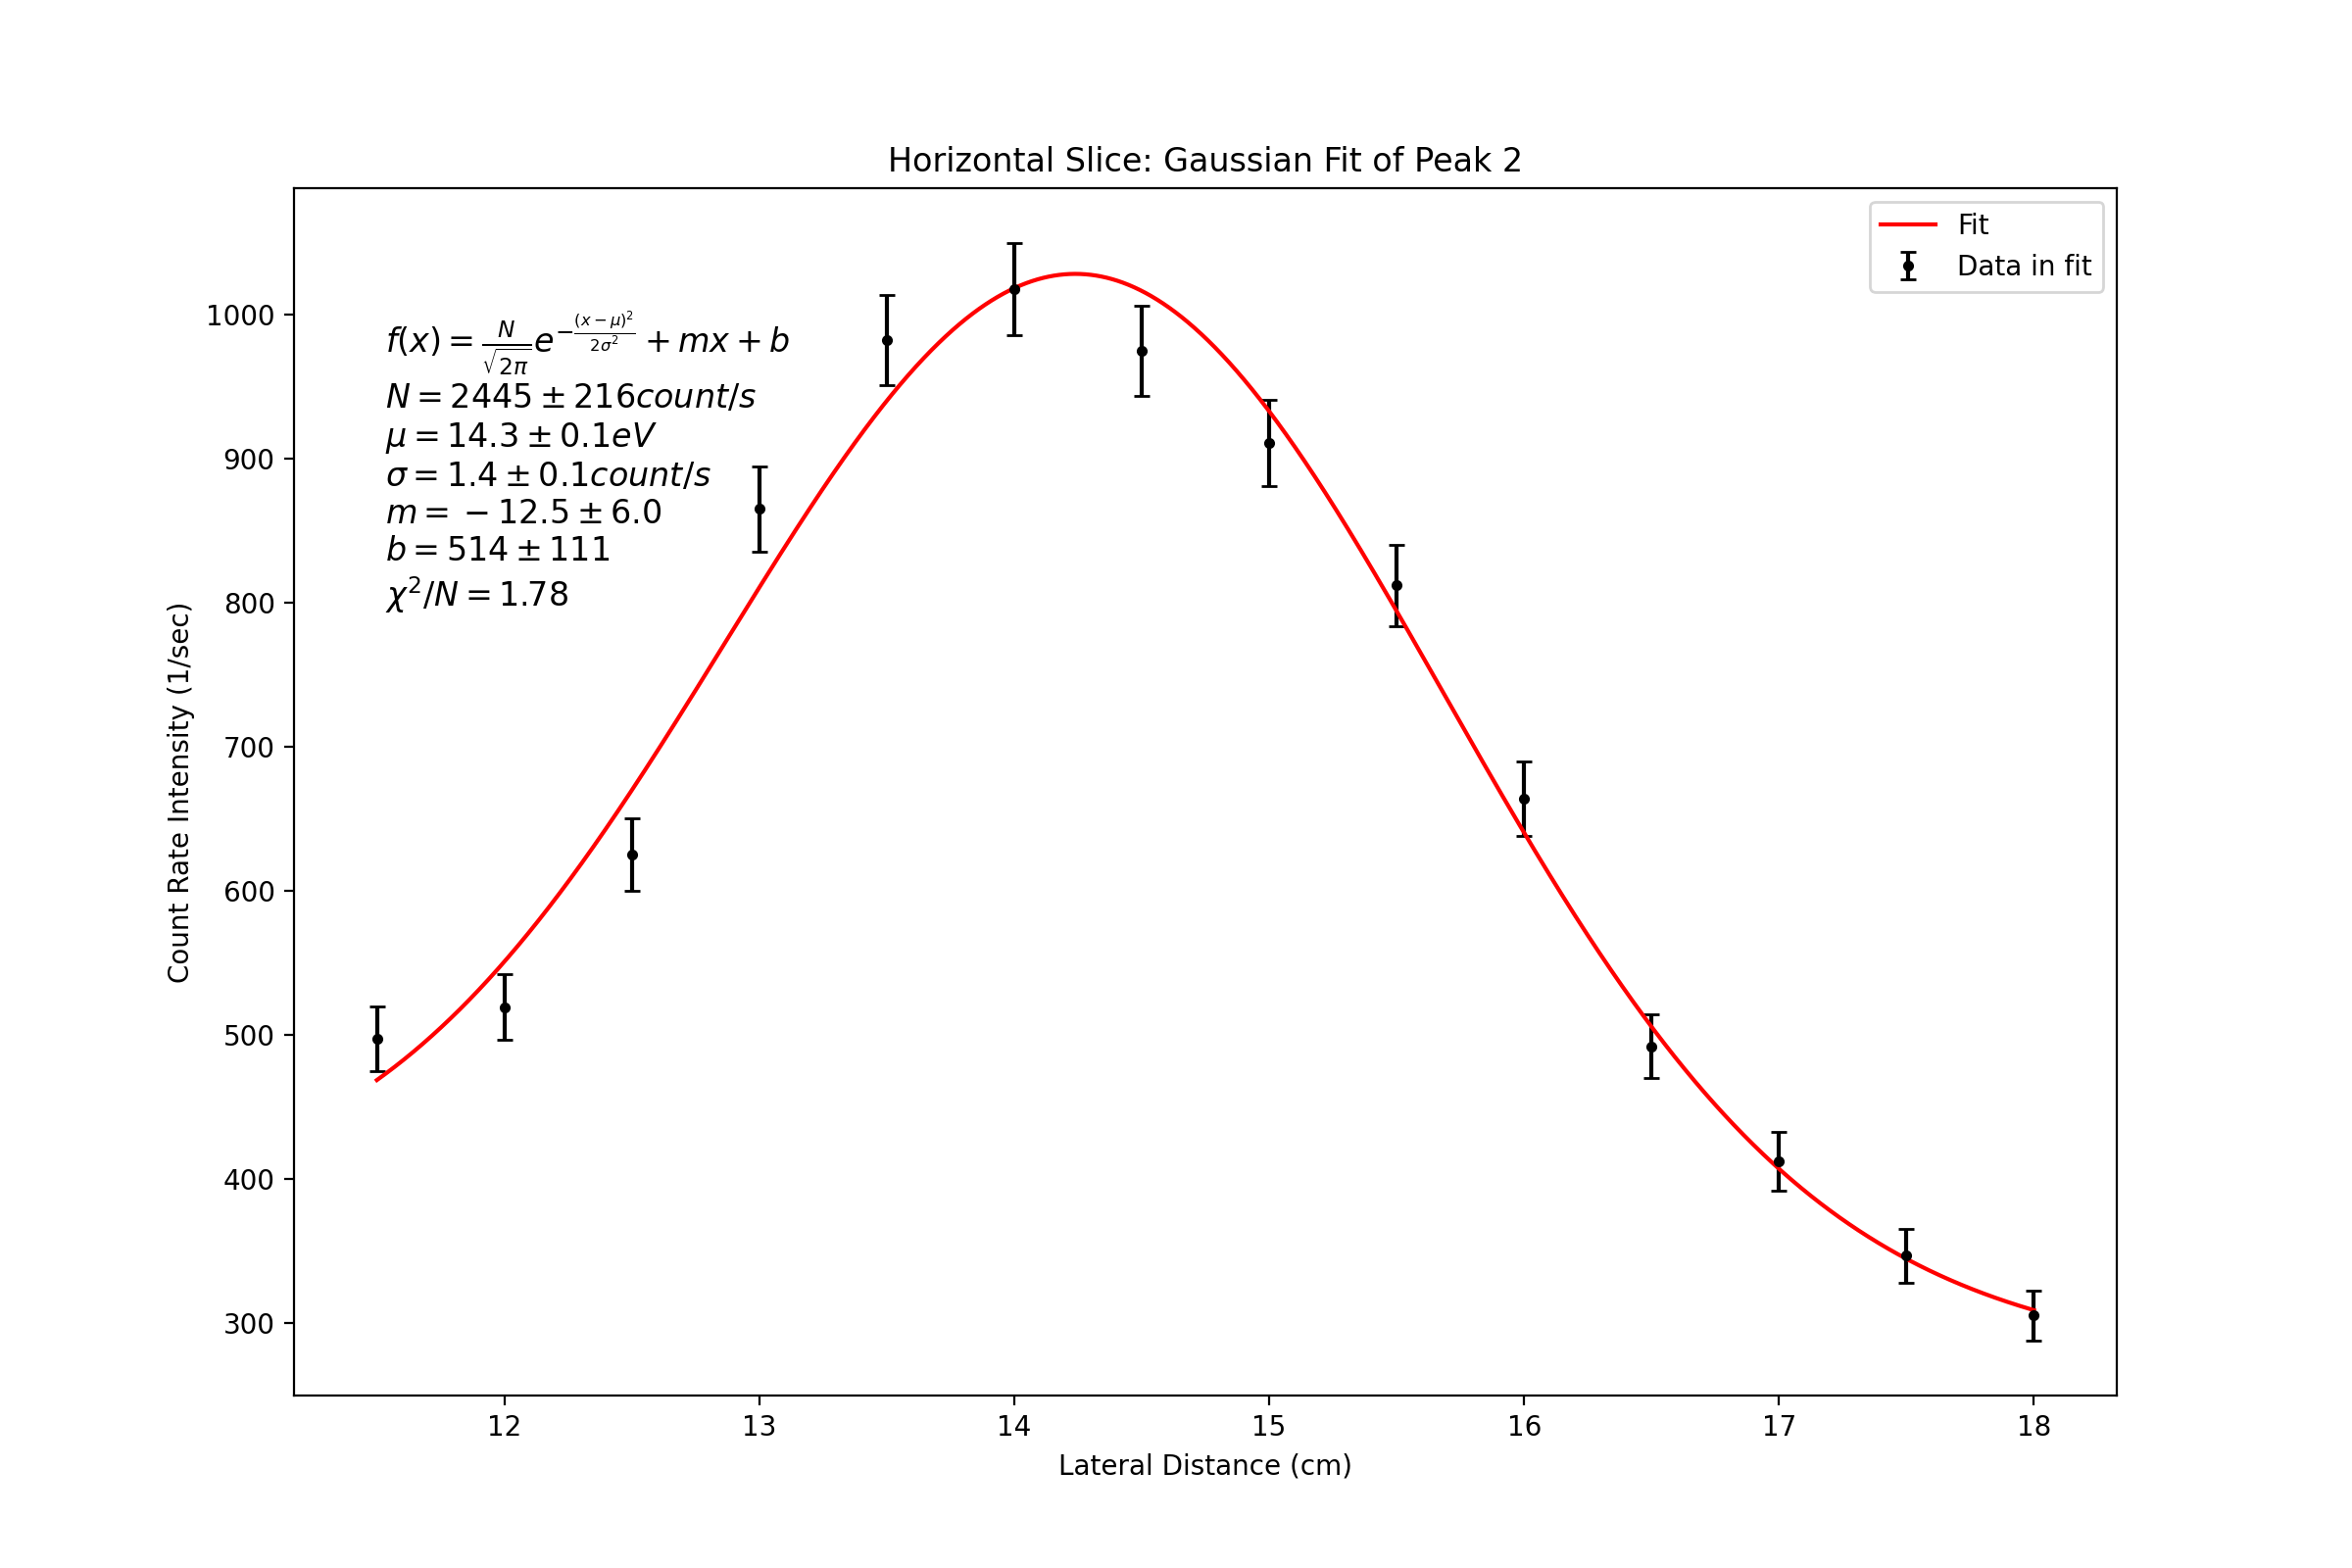

[11.5        11.50130026 11.50260052 ... 17.99739948 17.99869974
 18.        ]


In [659]:
guess = [3000,12,2,10,10]

min_value = 22
max_value = 36

pf, pferr, chisq, dof = data_fit(guess, gaussianfunc_bg, x[min_value:max_value], y[min_value:max_value], dy[min_value:max_value])

fig,ax = plt.subplots(figsize = (12,8))

ax.errorbar(x[min_value:max_value], y[min_value:max_value], yerr=dy[min_value:max_value],fmt= 'k.', capsize = 3, label='Data in fit')
channel_cont = np.linspace(min(x[min_value:max_value]), max(x[min_value:max_value]), 5000)

print(channel_cont)
ax.plot(channel_cont, gaussianfunc_bg(pf, channel_cont), 'r-', label='Fit')


#f(x) = \frac{N}{\sqrt{2\pi }}e^{-\frac{(x-\mu)^2}{2\sigma^2 }}
textfit = '$f(x) = \\frac{N}{\sqrt{2\pi }}e^{-\\frac{(x-\mu)^2}{2\sigma^2 }}+mx+b$\n' 
textfit += '$N = {:.0f} \pm {:.0f} count/s$ \n'.format(pf[0],pferr[0]) 
textfit += '$\mu = {:.1f} \pm {:.1f} eV$ \n'.format(pf[1],pferr[1]) 
textfit += '$\sigma = {:.1f} \pm {:.1f} count/s$ \n'.format(pf[2],pferr[2])
textfit += '$m = {:.1f} \pm {:.1f}$ \n'.format(pf[3],pferr[3]) 
textfit += '$b = {:.0f} \pm {:.0f}$ \n'.format(pf[4],pferr[4]) 
textfit += '$\chi^2 / N = {:.2f}$ \n'.format(chisq/dof) 
ax.text(0.05, 0.90, textfit, transform=ax.transAxes , fontsize=12,verticalalignment='top')

ax.set_title('Horizontal Slice: Gaussian Fit of Peak 2')
ax.legend()
ax.set_xlabel('Lateral Distance (cm)')
ax.set_ylabel('Count Rate Intensity (1/sec)')

plt.savefig('2source-peak2-horizontal.png')

# Vertical Gaussian Fits

<IPython.core.display.Javascript object>


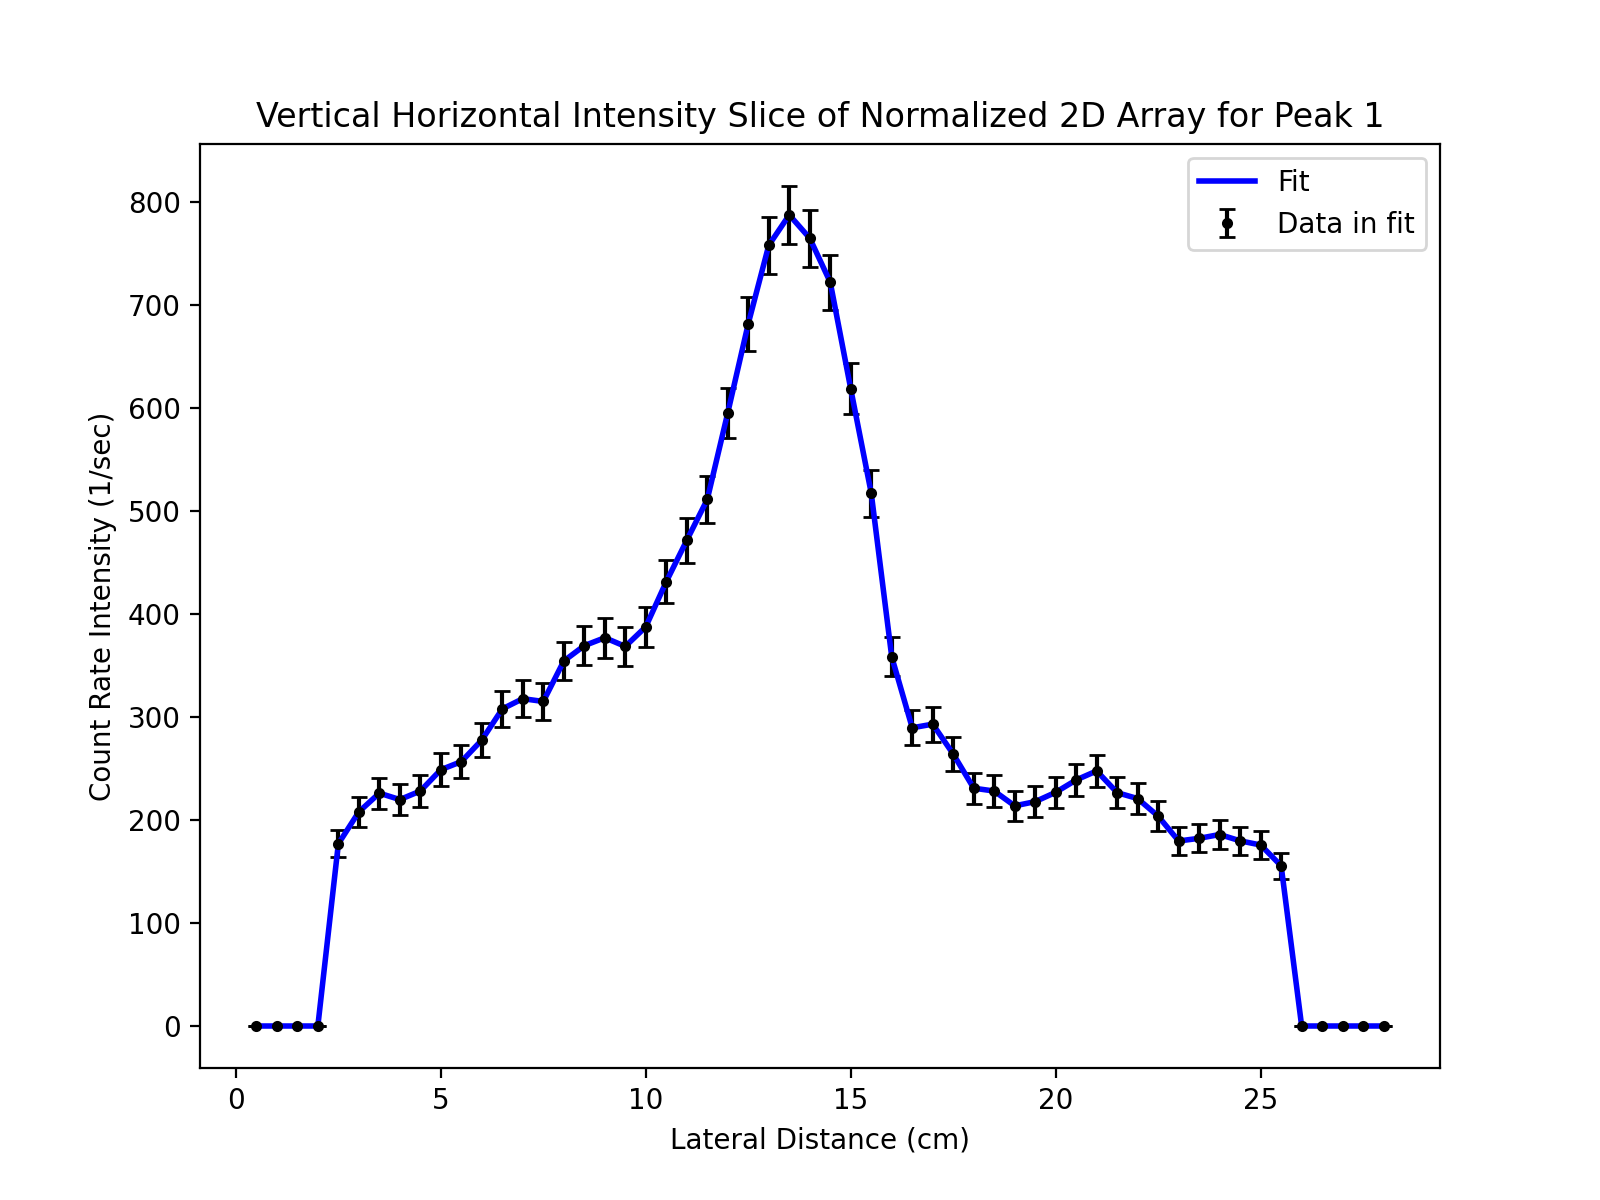

In [663]:
tnormalized = normalized.transpose()

y = tnormalized[13]
dy = np.sqrt(y)

fig,ax = plt.subplots(figsize = (8,6))


ax.errorbar(x, y, yerr = dy,fmt= 'k.', capsize = 3, label='Data in fit')
ax.plot(x, y, color = 'blue', linewidth = 2, label='Fit')



ax.set_title('Vertical Horizontal Intensity Slice of Normalized 2D Array for Peak 1')
ax.set_xlabel('Lateral Distance (cm)')
ax.set_ylabel('Count Rate Intensity (1/sec)')
ax.legend()

plt.savefig('2source-vertical13.png')


Converged with chi-squared 11.78
Number of degrees of freedom, dof = 10.00
Reduced chi-squared 1.18

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 8.000e+03                | 1.590e+03                | 1.304e+02               
1           | 1.200e+01                | 1.370e+01                | 6.158e-02               
2           | 2.000e+00                | 1.351e+00                | 8.026e-02               
3           | 1.000e+01                | -2.399e+01               | 3.567e+00               
4           | 1.000e+01                | 6.621e+02                | 6.048e+01               


<IPython.core.display.Javascript object>


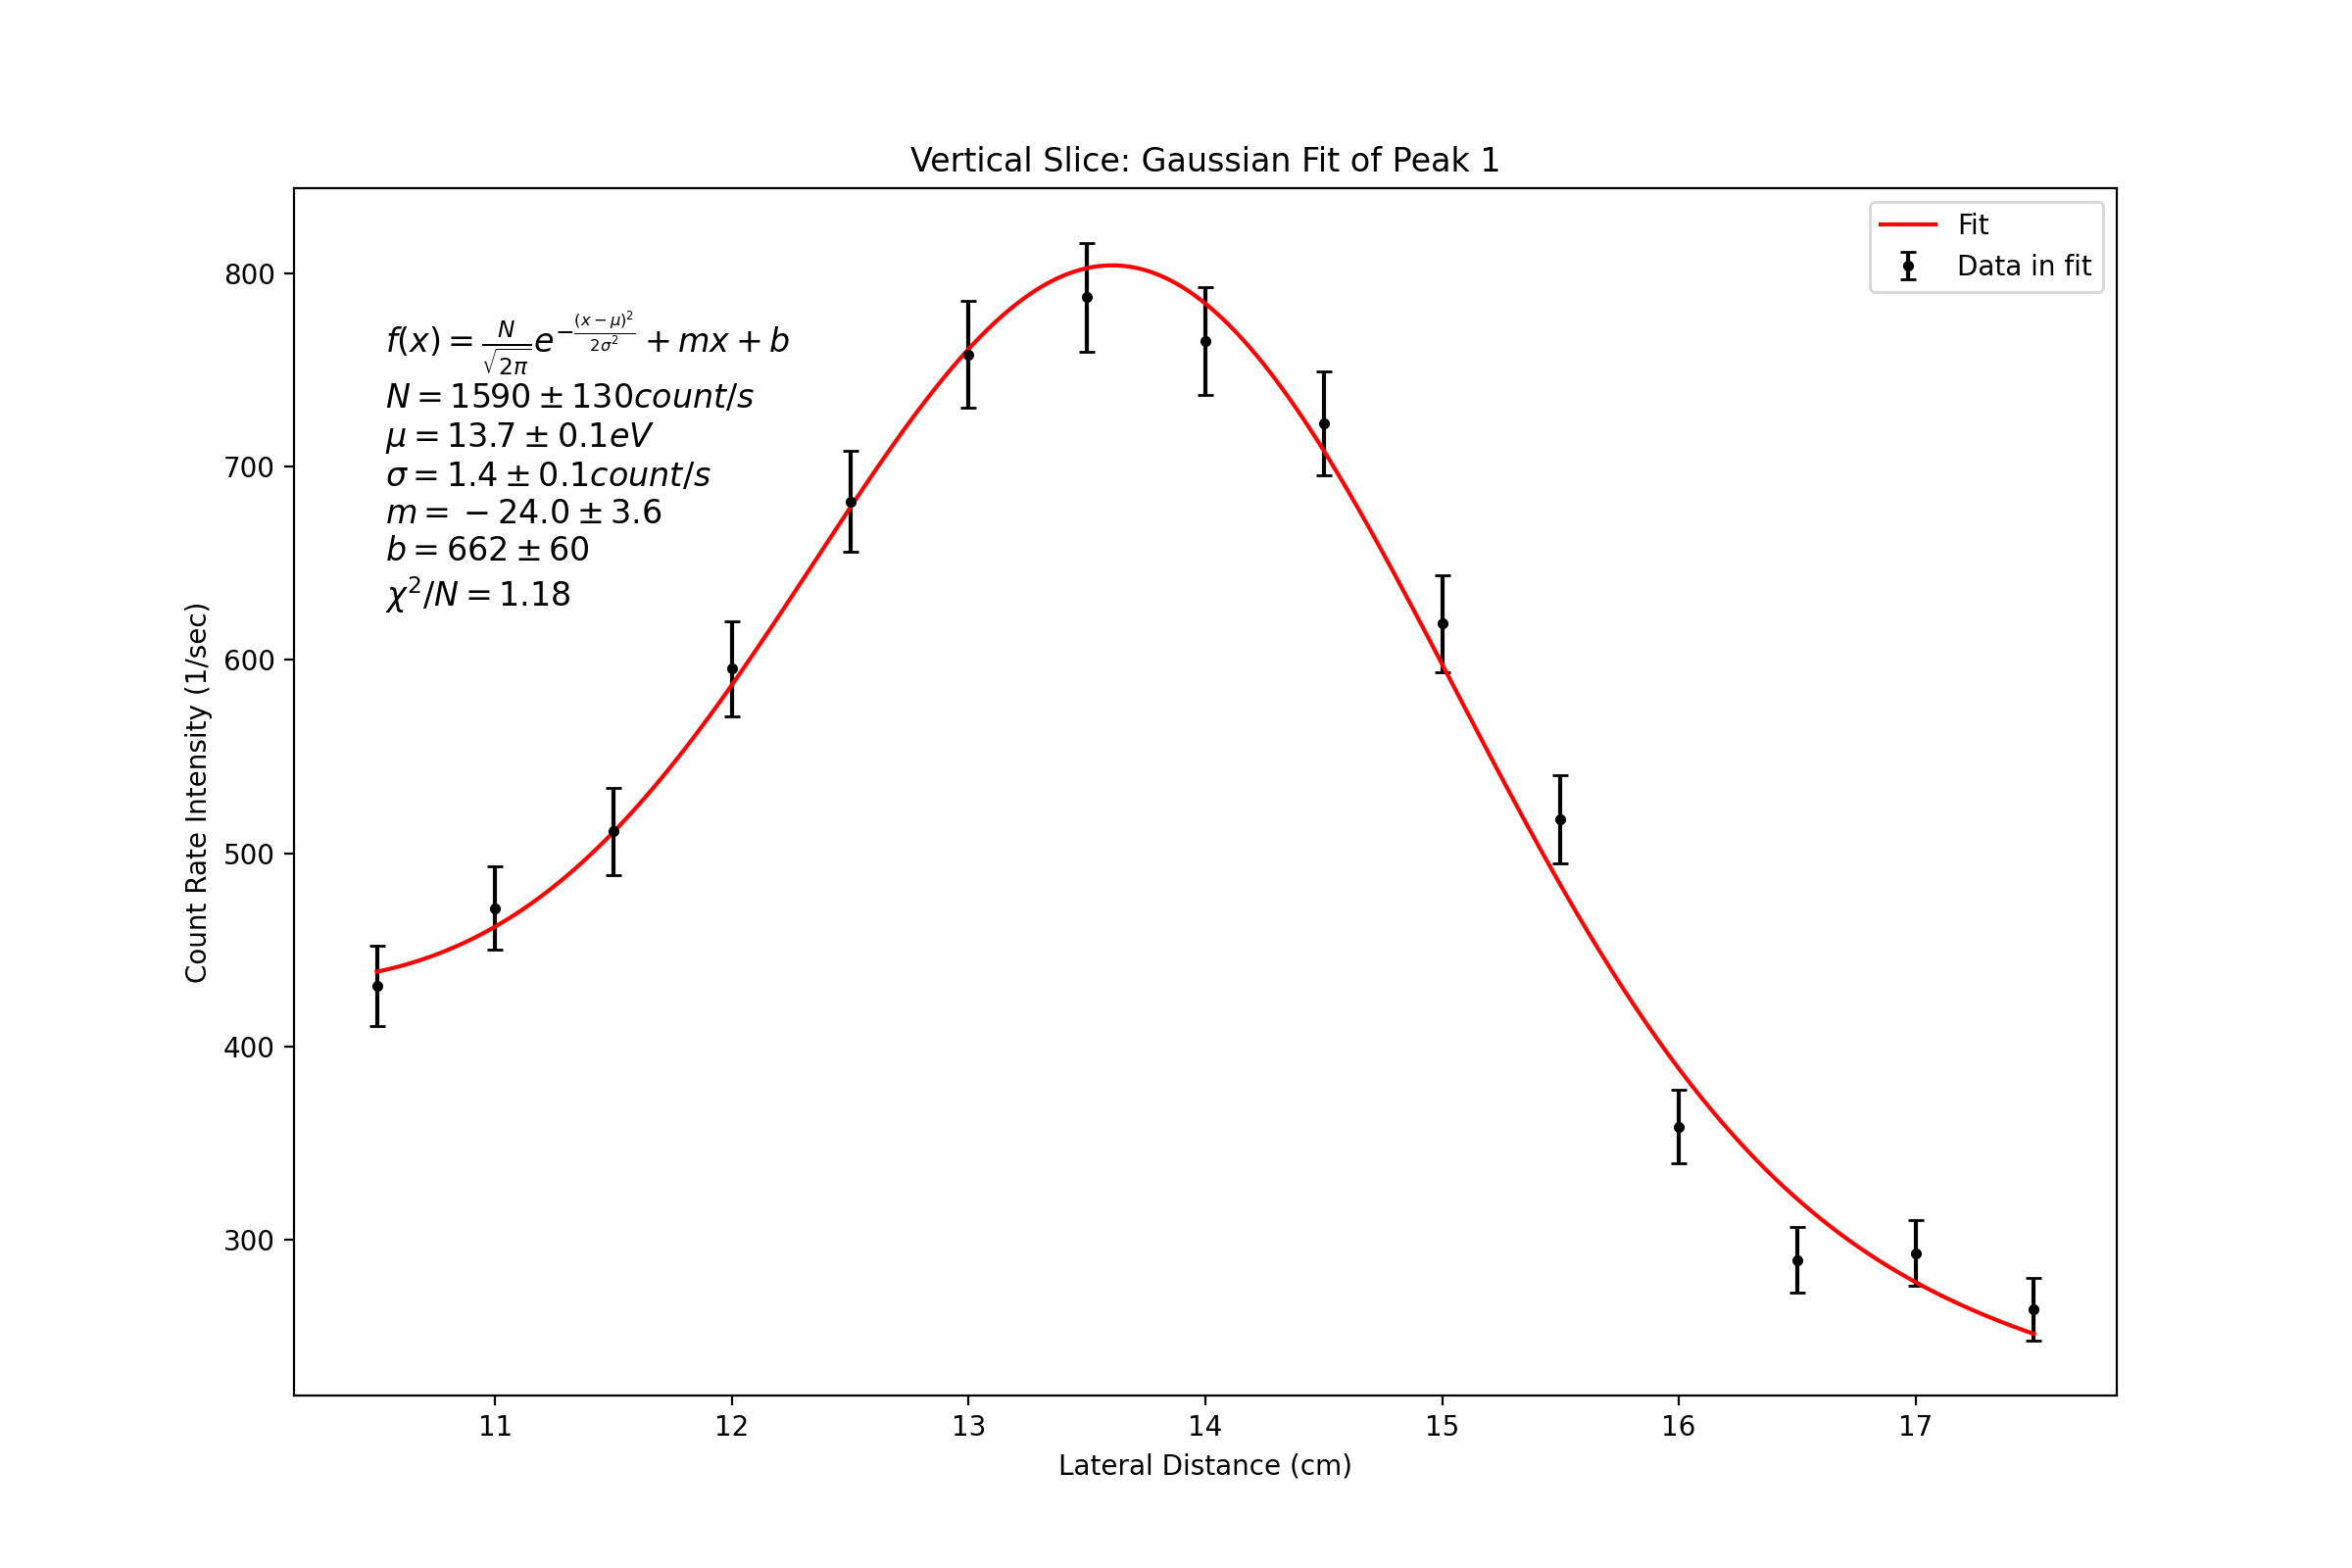

[10.5        10.50140028 10.50280056 ... 17.49719944 17.49859972
 17.5       ]


In [664]:
guess = [8000,12,2,10,10]

min_value = 20
max_value = 35

pf, pferr, chisq, dof = data_fit(guess, gaussianfunc_bg, x[min_value:max_value], y[min_value:max_value], dy[min_value:max_value])

fig,ax = plt.subplots(figsize = (12,8))

ax.errorbar(x[min_value:max_value], y[min_value:max_value], yerr=dy[min_value:max_value],fmt= 'k.', capsize = 3, label='Data in fit')
channel_cont = np.linspace(min(x[min_value:max_value]), max(x[min_value:max_value]), 5000)

print(channel_cont)
ax.plot(channel_cont, gaussianfunc_bg(pf, channel_cont), 'r-', label='Fit')


#f(x) = \frac{N}{\sqrt{2\pi }}e^{-\frac{(x-\mu)^2}{2\sigma^2 }}
textfit = '$f(x) = \\frac{N}{\sqrt{2\pi }}e^{-\\frac{(x-\mu)^2}{2\sigma^2 }}+mx+b$\n' 
textfit += '$N = {:.0f} \pm {:.0f} count/s$ \n'.format(pf[0],pferr[0]) 
textfit += '$\mu = {:.1f} \pm {:.1f} eV$ \n'.format(pf[1],pferr[1]) 
textfit += '$\sigma = {:.1f} \pm {:.1f} count/s$ \n'.format(pf[2],pferr[2])
textfit += '$m = {:.1f} \pm {:.1f}$ \n'.format(pf[3],pferr[3]) 
textfit += '$b = {:.0f} \pm {:.0f}$ \n'.format(pf[4],pferr[4]) 
textfit += '$\chi^2 / N = {:.2f}$ \n'.format(chisq/dof) 
ax.text(0.05, 0.90, textfit, transform=ax.transAxes , fontsize=12,verticalalignment='top')

ax.set_title('Vertical Slice: Gaussian Fit of Peak 1')
ax.legend()
ax.set_xlabel('Lateral Distance (cm)')
ax.set_ylabel('Count Rate Intensity (1/sec)')

plt.savefig('2source-peak1-vertical.png')


<IPython.core.display.Javascript object>


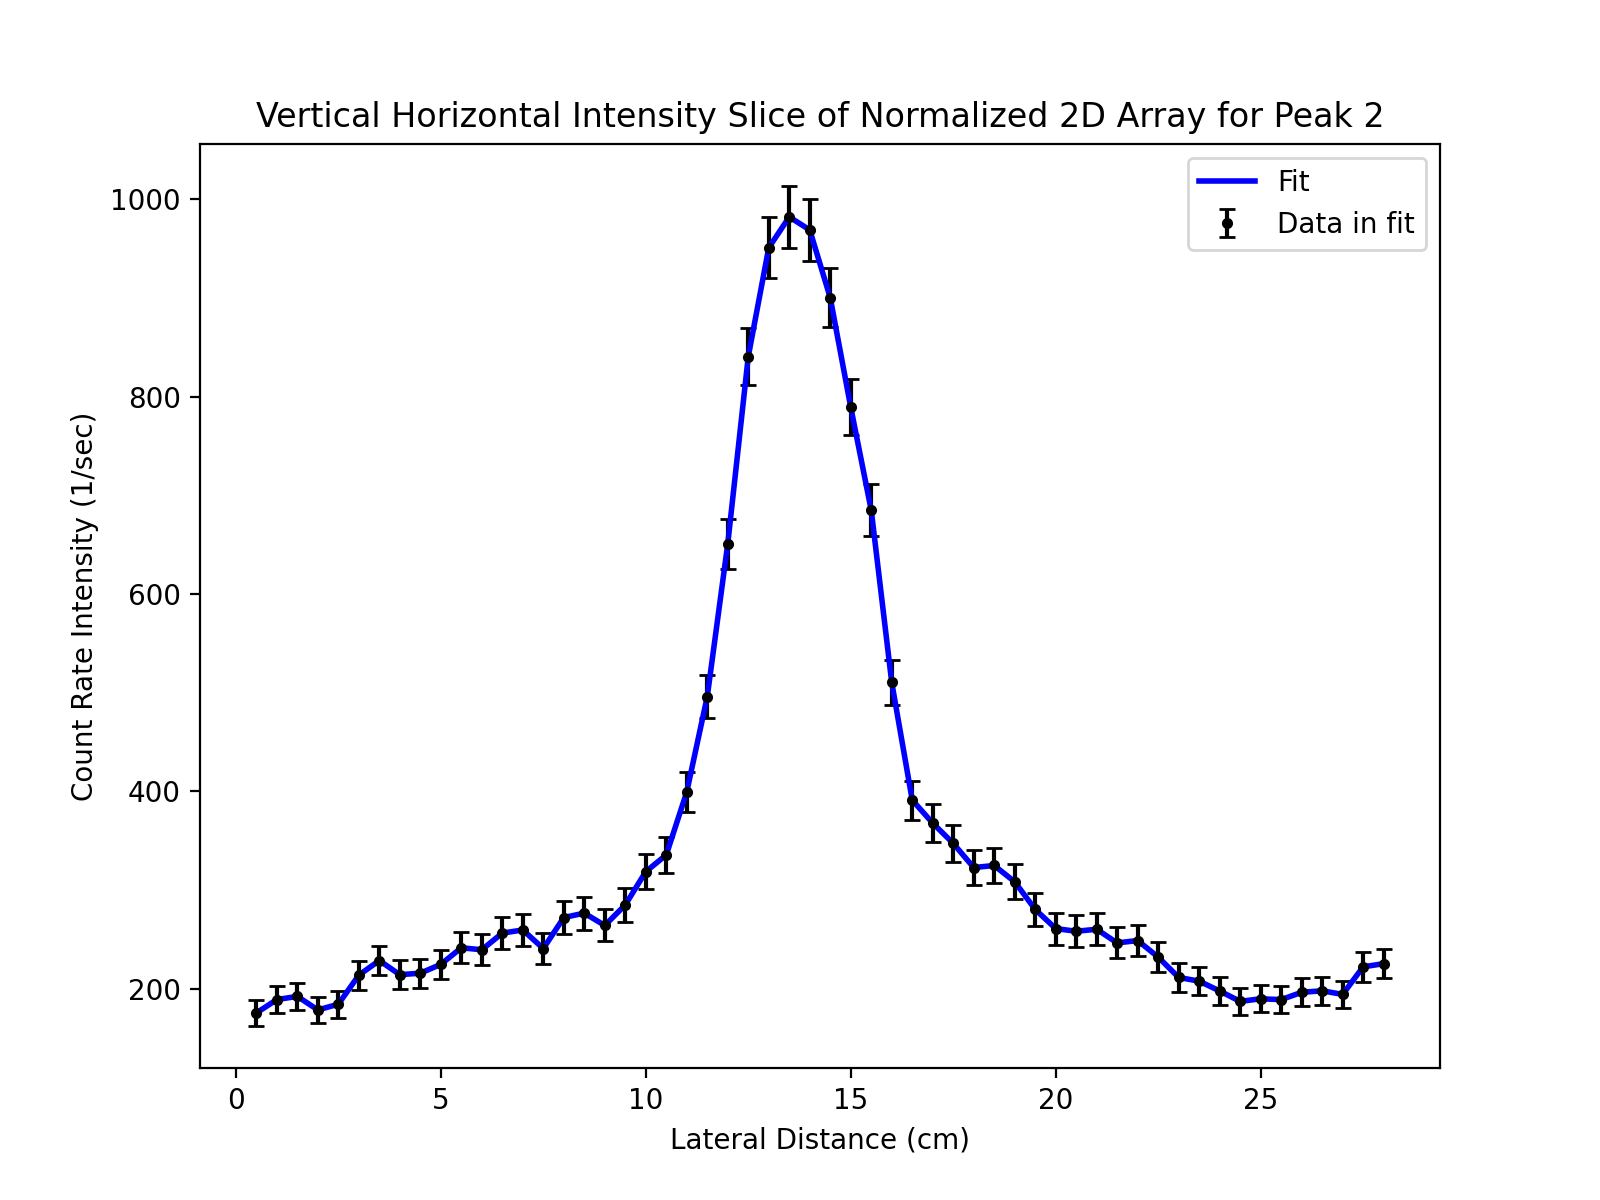

In [665]:
tnormalized = normalized.transpose()

y = tnormalized[26]
dy = np.sqrt(y)

fig,ax = plt.subplots(figsize = (8,6))


ax.errorbar(x, y, yerr = dy,fmt= 'k.', capsize = 3, label='Data in fit')
ax.plot(x, y, color = 'blue', linewidth = 2, label='Fit')



ax.set_title('Vertical Horizontal Intensity Slice of Normalized 2D Array for Peak 2')
ax.set_xlabel('Lateral Distance (cm)')
ax.set_ylabel('Count Rate Intensity (1/sec)')
ax.legend()

plt.savefig('2source-vertical26.png')


Converged with chi-squared 11.67
Number of degrees of freedom, dof = 11.00
Reduced chi-squared 1.06

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 8.000e+03                | 2.623e+03                | 1.337e+02               
1           | 1.400e+01                | 1.370e+01                | 4.328e-02               
2           | 2.000e+00                | 1.458e+00                | 5.659e-02               
3           | 1.000e+01                | 5.005e+00                | 2.901e+00               
4           | 1.000e+01                | 2.254e+02                | 4.341e+01               


<IPython.core.display.Javascript object>


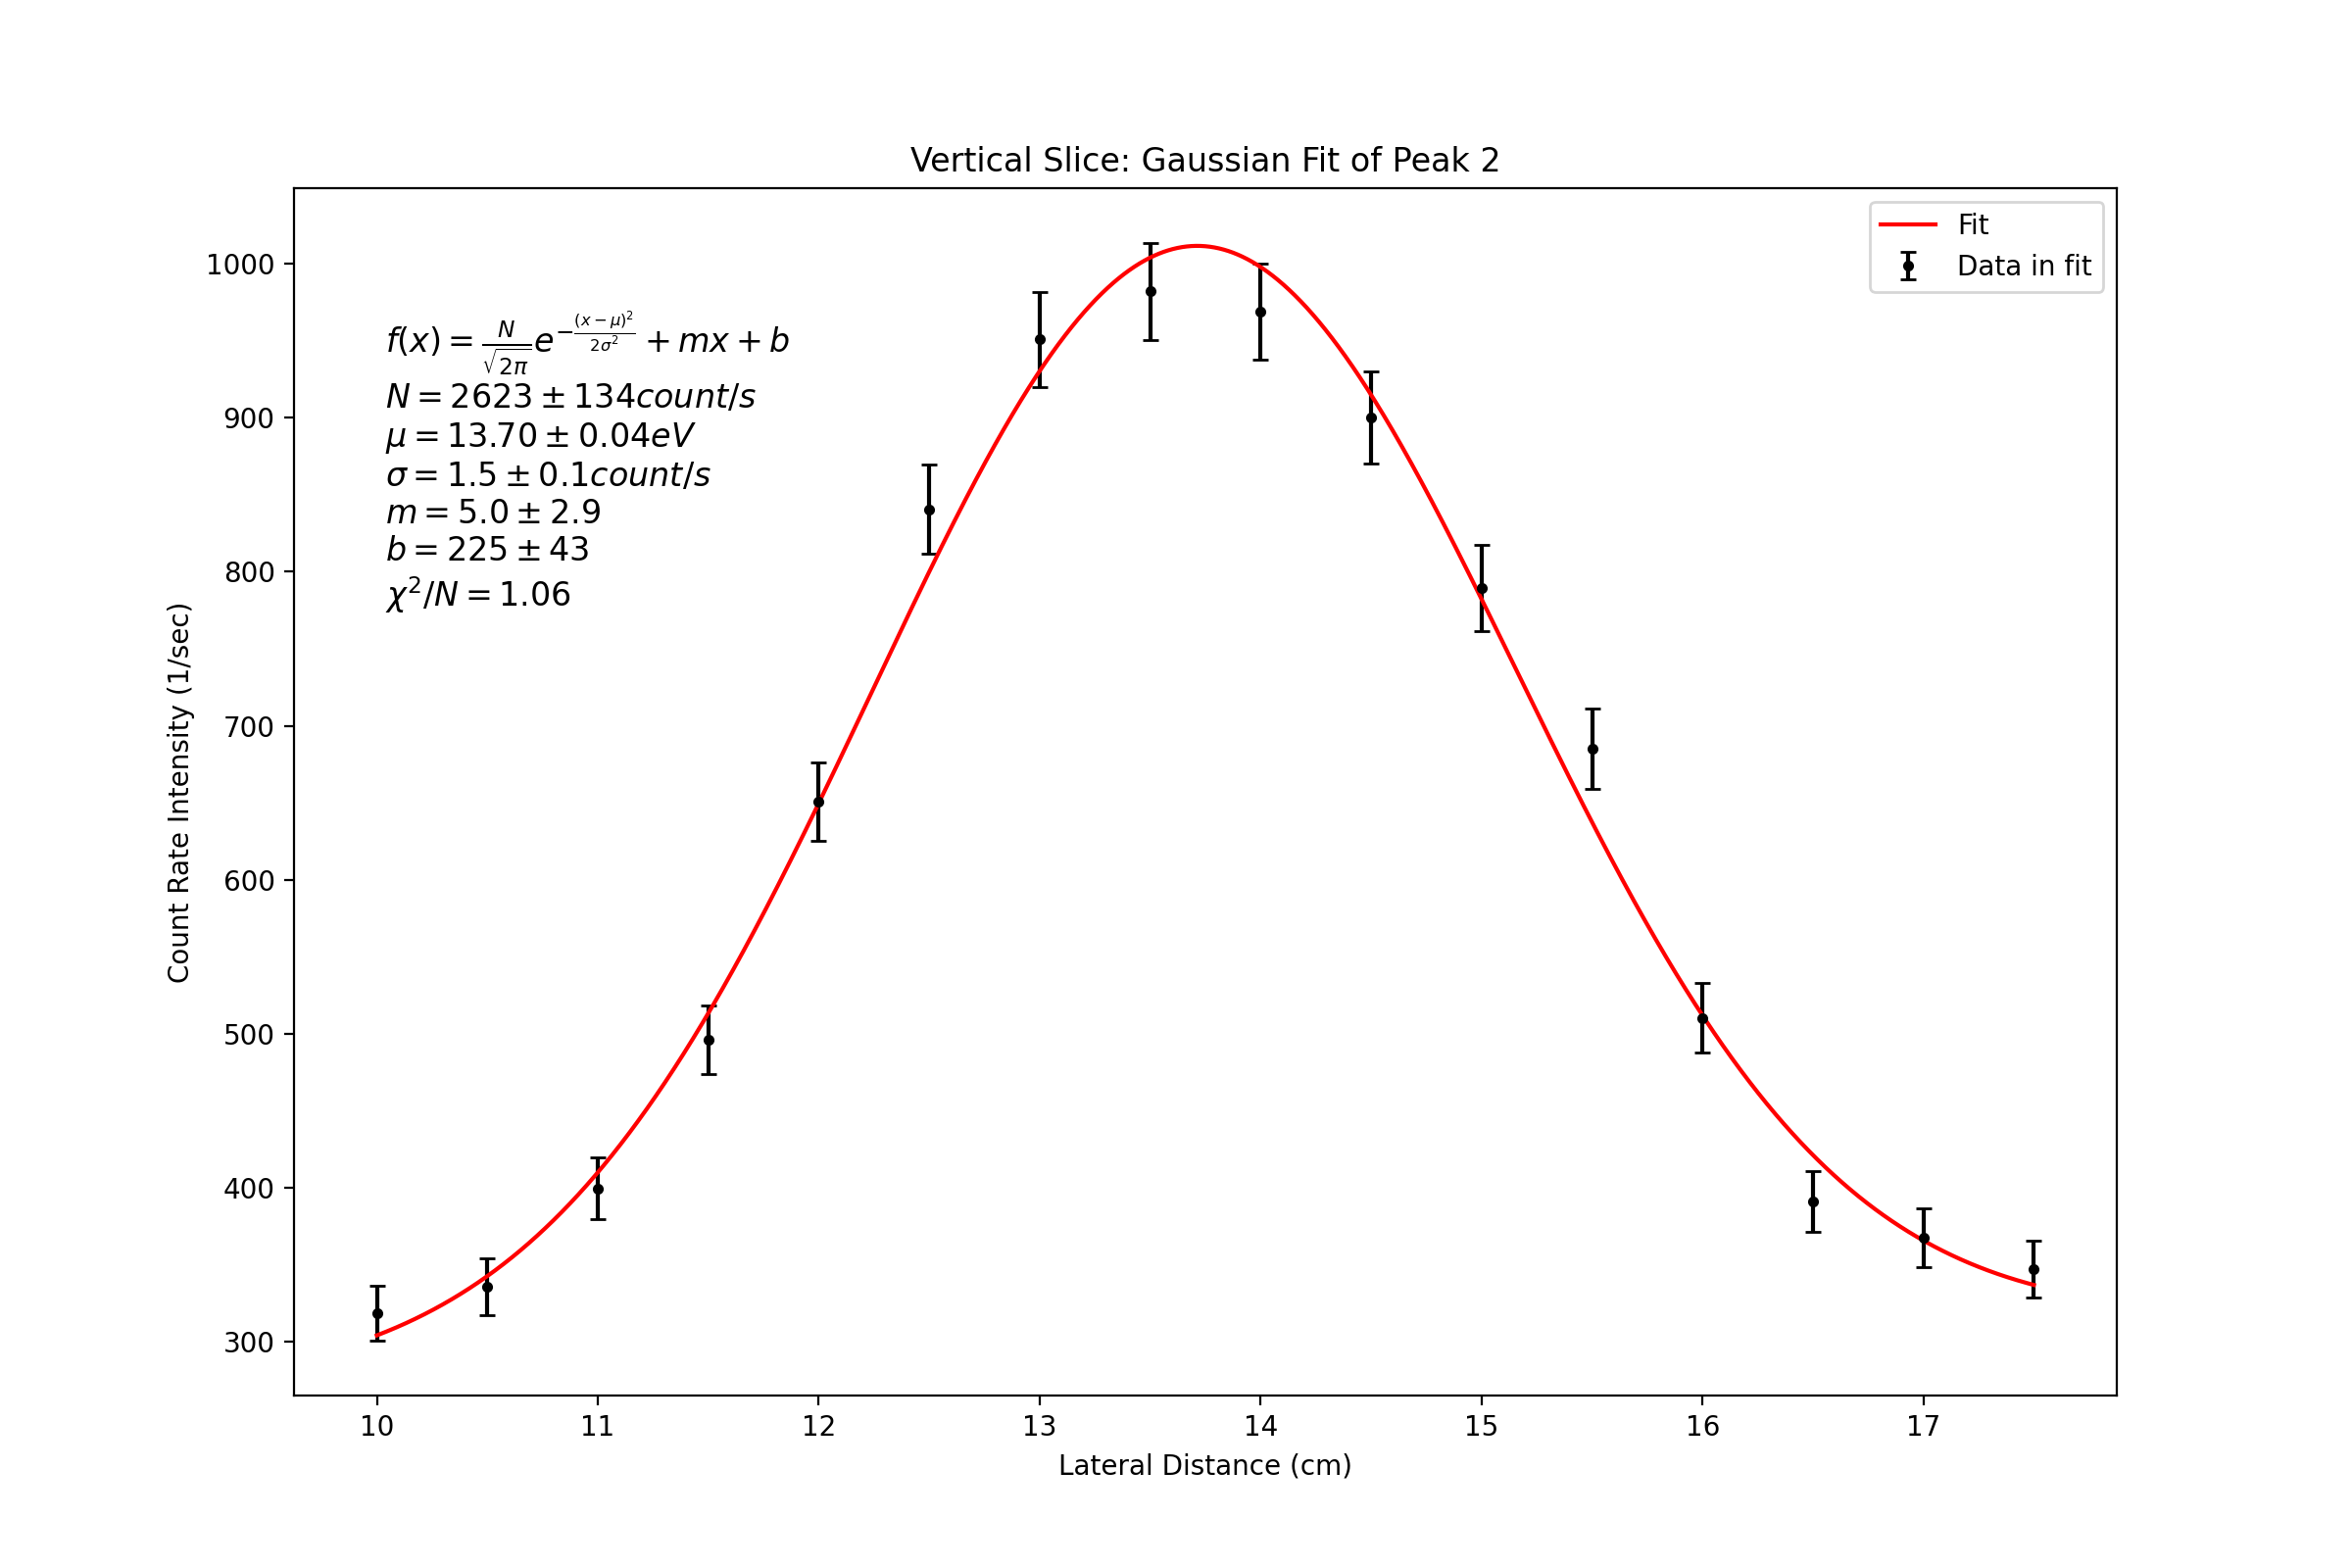

[10.        10.0015003 10.0030006 ... 17.4969994 17.4984997 17.5      ]


In [667]:
guess = [8000,14,2,10,10]

min_value = 19
max_value = 35

pf, pferr, chisq, dof = data_fit(guess, gaussianfunc_bg, x[min_value:max_value], y[min_value:max_value], dy[min_value:max_value])

fig,ax = plt.subplots(figsize = (12,8))

ax.errorbar(x[min_value:max_value], y[min_value:max_value], yerr=dy[min_value:max_value],fmt= 'k.', capsize = 3, label='Data in fit')
channel_cont = np.linspace(min(x[min_value:max_value]), max(x[min_value:max_value]), 5000)

print(channel_cont)
ax.plot(channel_cont, gaussianfunc_bg(pf, channel_cont), 'r-', label='Fit')


#f(x) = \frac{N}{\sqrt{2\pi }}e^{-\frac{(x-\mu)^2}{2\sigma^2 }}
textfit = '$f(x) = \\frac{N}{\sqrt{2\pi }}e^{-\\frac{(x-\mu)^2}{2\sigma^2 }}+mx+b$\n' 
textfit += '$N = {:.0f} \pm {:.0f} count/s$ \n'.format(pf[0],pferr[0]) 
textfit += '$\mu = {:.2f} \pm {:.2f} eV$ \n'.format(pf[1],pferr[1]) 
textfit += '$\sigma = {:.1f} \pm {:.1f} count/s$ \n'.format(pf[2],pferr[2])
textfit += '$m = {:.1f} \pm {:.1f}$ \n'.format(pf[3],pferr[3]) 
textfit += '$b = {:.0f} \pm {:.0f}$ \n'.format(pf[4],pferr[4]) 
textfit += '$\chi^2 / N = {:.2f}$ \n'.format(chisq/dof) 
ax.text(0.05, 0.90, textfit, transform=ax.transAxes , fontsize=12,verticalalignment='top')

ax.set_title('Vertical Slice: Gaussian Fit of Peak 2')
ax.legend()
ax.set_xlabel('Lateral Distance (cm)')
ax.set_ylabel('Count Rate Intensity (1/sec)')

plt.savefig('2source-peak2-vertical.png')



# Alternate Plot Types
----
We can also make contour plots, showing regions of equal intensity.

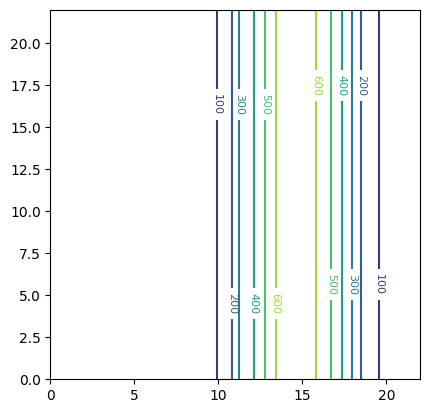

In [23]:
fig, ax = plt.subplots()

x = np.linspace(0,22,len(normalized)) 
y = np.linspace(0,22,len(normalized))
X, Y = np.meshgrid(x, y) # These set up a coordinate system for the contour plot

num_lines = 6
flipped = normalized[::-1] # This is Python sorcery that flips the data vertically so that it matches the other plots.

p = ax.contour(X, Y, flipped,num_lines)
ax.clabel(p, inline=True, fontsize=8) # This adds numbers to contours
ax.set_aspect('equal')

Another useful option is to make a fully 3d projection

<IPython.core.display.Javascript object>


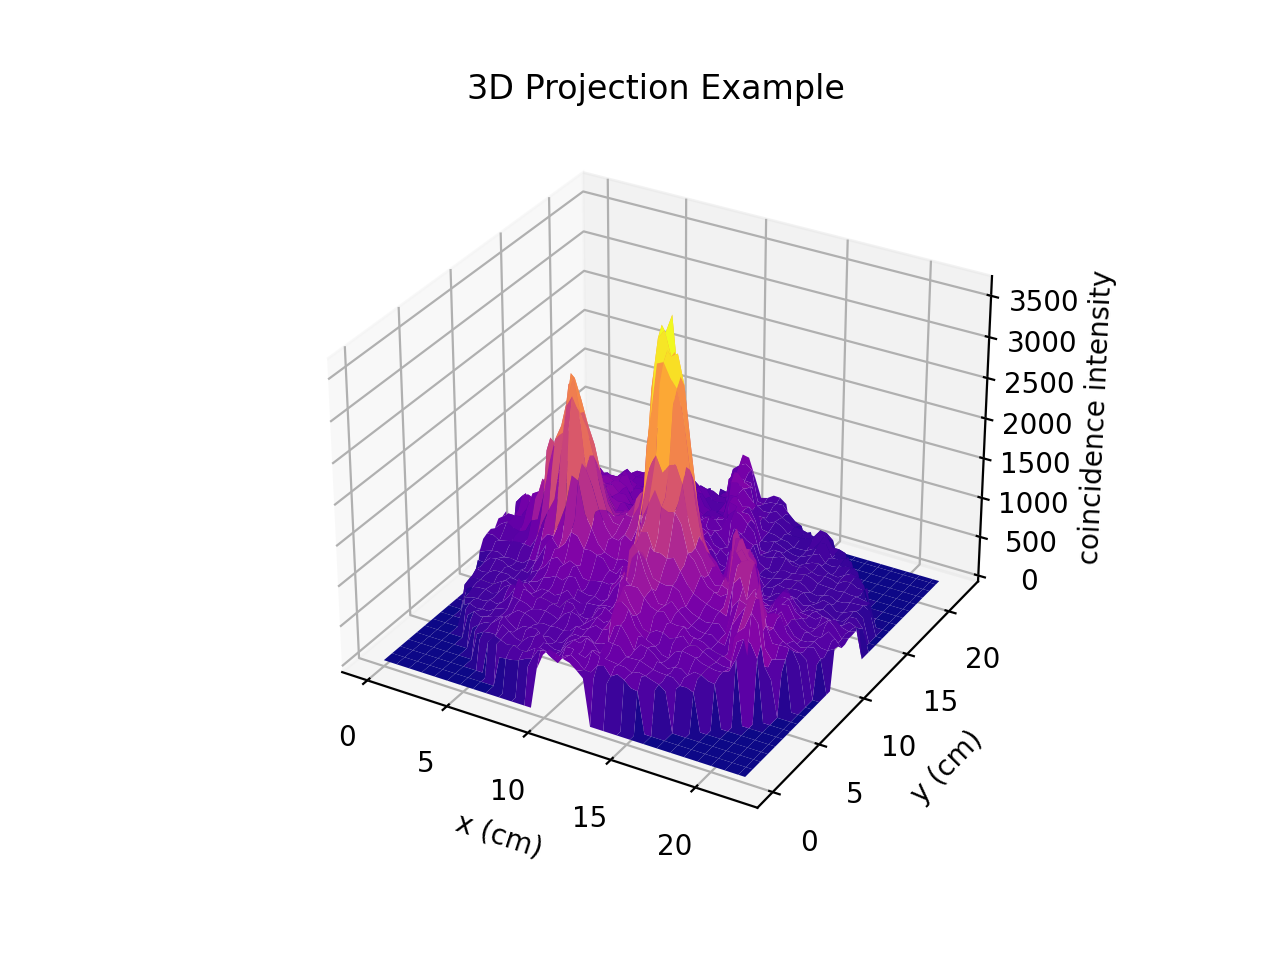

In [505]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(0,22,len(normalized)) 
y = np.linspace(0,22,len(normalized))
X, Y = np.meshgrid(x, y) # These set up a coordinate system for the contour plot

ax.plot_surface(X, Y, flipped,cmap='plasma') #color maps are not required
ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
ax.set_zlabel('coincidence intensity')
ax.set_title('3D Projection Example');

We can also do this for each of our slices, giving a 3d view of how our reconstruction step-by-step.

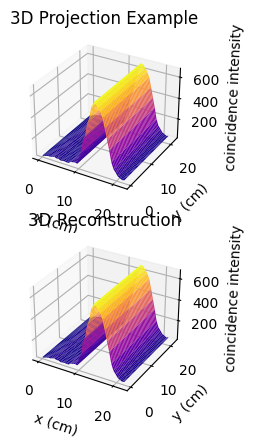

In [24]:
composite = np.ones_like(rotated_data[0]) 
for index, item in enumerate(rotated_data):
    fig = plt.figure()
    ax = fig.add_subplot(211, projection='3d')
    ay = fig.add_subplot(212, projection='3d')
    
    x = np.linspace(0,22,len(item)) 
    y = np.linspace(0,22,len(item))
    X, Y = np.meshgrid(x, y) # These set up a coordinate system for the contour plot
    
    ax.plot_surface(X, Y, item,cmap='plasma') #color maps are not required
    composite *= item   
    ay.plot_surface(X, Y, np.power(composite,(1/(index+1))),cmap='plasma') #color maps are not required
    
    ax.set_xlabel('x (cm)')
    ax.set_ylabel('y (cm)')
    ax.set_zlabel('coincidence intensity')
    ax.set_title('3D Projection Example')
    
    ay.set_xlabel('x (cm)')
    ay.set_ylabel('y (cm)')
    ay.set_zlabel('coincidence intensity')
    ay.set_title('3D Reconstruction')

# Advanced Techniques
----
We can do a few things to improve our reconstruction technique here.  To start, let's see if we can do something about the jaggedness of the rotations.  We can do this by repeating values in the slices multiple times, so there's more space for interpolation.

There are any number of ways to accomplish this, and probably some better than this, but this will get the job done.

In [25]:
expansion_value = 2
expanded_slice = [np.array([])]
for index,slices in enumerate(data):
    for element in slices:  # This goes through each slice one item at a time
        repeat_values = np.full(expansion_value,element) # makex an x by 1 array full of one value
        expanded_slice[index] = np.append(expanded_slice[index], repeat_values) # This tacks on the expanded bit on the end of our array
    expanded_slice.append(np.array([])) # This adds a new empty array to the end of things
expanded_slice.pop()    #We accidentally create an extra empty array, so this gets rid of it
print(data[0])
print(expanded_slice[0])

[ 27.   31.   36.5  42.   42.   48.   54.   45.   47.   37.   40.   42.
  38.   40.   56.   59.   64.   58.  128.  176.  309.  346.  464.  518.
 625.  669.  663.  633.  603.  556.  467.  373.  282.  176.  117.   90.
  61.   50.   39.   45. ]
[ 27.   27.   31.   31.   36.5  36.5  42.   42.   42.   42.   48.   48.
  54.   54.   45.   45.   47.   47.   37.   37.   40.   40.   42.   42.
  38.   38.   40.   40.   56.   56.   59.   59.   64.   64.   58.   58.
 128.  128.  176.  176.  309.  309.  346.  346.  464.  464.  518.  518.
 625.  625.  669.  669.  663.  663.  633.  633.  603.  603.  556.  556.
 467.  467.  373.  373.  282.  282.  176.  176.  117.  117.   90.   90.
  61.   61.   50.   50.   39.   39.   45.   45. ]


The expanded_slice here is just the same values, but doubled up in the array.  Now we'll do our matrix expansion and rotation, and see what the difference is.

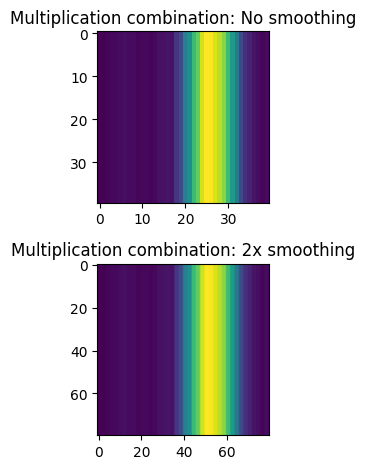

In [26]:
expand_vec = np.ones(expanded_slice[0].size)
expanded_rotation = []
for index, item in enumerate(expanded_slice):
    expanded_rotation.append(ndimage.rotate(np.outer(expand_vec,item),angles[index],reshape=False))

expanded_composite = np.ones_like(expanded_rotation[0])
for item in expanded_rotation:
    expanded_composite *= item
expanded_normalized = np.power(expanded_composite,(1/len(data)))

fig, (ax,ay) = plt.subplots(2)
ax.imshow(normalized)
ax.set_title("Multiplication combination: No smoothing")    
ay.imshow(expanded_normalized)
ay.set_title("Multiplication combination: 2x smoothing")
fig.tight_layout()

This does a lot to get rid of some of the jaggedness of the reconstruction, but there are also likely some shadows caused by us having multiple sources here.

We can also use a professional reconstruction technique: a [radon transform](https://en.wikipedia.org/wiki/Radon_transform).  At heart this technique uses a Fourier transform of slices, recombines these in a polar format, and then does an inverse Fourier transform.  You can try and work this out for yourself, but we can also use a package from `skimage` to do this for us with our data.  Since we're starting with slice/angle data, we'll be doing an inverse transformation.

You'll need to install the package in Anaconda for this to work.

In [27]:
from skimage.transform import iradon
reconstruction = iradon(np.transpose(np.array(data)),theta=np.array(angles)) 
# the transpose makes it line up with our other method

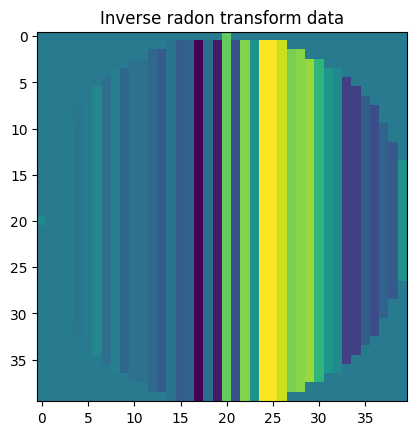

In [28]:
fig, ax = plt.subplots()
ax.imshow(reconstruction)
ax.set_title("Inverse radon transform data");

As expected the results are similar, but there are some differences in the intensities.